# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<BR/>
pre-testing for 19.12 release, December 2019.

In [1]:
minitest_version = '19.12'

## Basic setup to run this yourself at NERSC
On cori.nersc.gov, clone desitest:
```
git clone https://github.com/desihub/desitest
```
If needed, checkout the branch with the version you'd like to test, e.g.:
```
cd desitest
git checkout automini
```
This notebook and its configuration files are in desitest/mini.

Configure the desi test-release jupyter notebook kernel for your account following the instructions at https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC. Then go to https://jupyter.nersc.gov, navigate to where you checked out desitest/mini and start your own copy of this notebook.
To get the same version of code with an interactive login:
```
source /project/projectdirs/desi/software/desi_environment.sh master
```
(or desi_environment.csh for t/csh users)

## Running this notebook

Some steps of this notebook directly spawn batch jobs and wait for them to finish. These steps log to a different file so that the notebook isn't cluttered with N>>1 lines of output. Steps that take more than a few minutes should indicate how long they expect to take and when they started. Go check the logfile and/or run `squeue -u $USER` from a command line to check on things if you think they are stuck.

If everything runs successfully with minimal queue wait times, the entire notebook should run end-to-end in about 2 hours. Each step automatically recognizes whether it has already been successfully run and skips expensive processing steps if they aren't needed. Thus if you need to restart, you can always just start from the very beginning and it will quickly catch up to the next substantive step to do.

If you want to force reprocessing of everything, remove the minitest directory from `$SCRATCH/` (see the `minitest_version` variable defined above) and then restart the notebook from the beginning.

This notebook will take ~1500 MPP hours at NERSC. Check your balance at https://nim.nersc.gov to make sure you have enough before starting.

In [2]:
# This should always be first because calling it later can screw up the namespace.
import desitarget

%pylab inline

import os, sys, glob, time, subprocess, time, shutil
import numpy as np
import healpy as hp
from astropy.table import Table, join
from astropy.io import fits
import fitsio
#- Some of these are imported just to establish versions
#- but aren't used in the notebook itself
import desisim
import desispec.io
from desispec.scripts import pipe
import desitarget.io
from desitarget.targetmask import desi_mask
import desimodel.io
import desimodel.footprint
import desisurvey
import surveysim
import specsim
from surveysim.util import add_calibration_exposures
import desiutil.depend
import specter
import redrock
import simqso

print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Populating the interactive namespace from numpy and matplotlib
Starting at Fri Dec 27 09:03:29 2019


## Define the code versions used for this notebook

In [3]:
print(os.environ['DESIMODULES'])

deps = dict()

desiutil.depend.add_dependencies(deps)
desiutil.depend.setdep(deps, 'simqso', simqso.__version__)

for p in ('dust', 'desimodules'):
    if p.upper()+'_VERSION' in os.environ:
        desiutil.depend.setdep(deps, p, os.environ[p.upper()+'_VERSION'])

for codename, version in desiutil.depend.iterdep(deps):
    print('  {:12s} {}'.format(codename, version))

/global/common/software/desi/cori/desiconda/startup/modulefiles/desimodules
  python       3.6.6
  numpy        1.16.4
  scipy        1.3.0
  astropy      2.0.14
  yaml         5.1.1
  matplotlib   2.1.2
  fitsio       0.9.11
  healpy       1.12.9
  desiutil     2.0.1
  desispec     0.32.1
  desitarget   0.35.2
  desimodel    0.10.3
  desisim      0.34.2
  desisurvey   0.12.1
  specter      0.9.1
  speclite     0.9dev514
  specsim      0.13
  surveysim    0.11.0
  redrock      0.14.2
  simqso       1.2.3
  dust         v0_1
  desimodules  test-release


## Set some environment variables and create output directories

The next cell will create directories under `$SCRATCH/` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | `$DESISURVEY_OUTPUT`                              |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | `$DESI_SPECTRO_REDUX/$SPECPROD`                   |
| spectro/sim/mini/     | simdatadir    | `$DESI_SPECTRO_DATA = $DESI_SPECTRO_SIM/$PIXPROD` |

It additionally derives the location of the base directory as the notebook
variable `minitestdir` for use in later cells.


In [4]:
basedir      = os.path.join(os.environ['SCRATCH'], 'minitest-'+minitest_version)

surveydir    = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
targetdir    = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')
minitestdir  = os.getcwd()

desimodules_version = os.environ['DESIMODULES_VERSION']

os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM']   = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD']  = 'mini'
os.environ['SPECPROD'] = 'mini'

# os.environ['DESI_CCD_CALIBRATION_DATA'] = os.getenv('DESI_ROOT')+'/spectro/ccd_calibration_data/trunk/'

reduxdir   = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])

os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

if 'csh' in os.environ['SHELL']:
    envcmd = "source /project/projectdirs/desi/software/desi_environment.csh {}".format(desimodules_version)
    envcmd += """
set basedir = ${basedir}
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}
setenv DESI_CCD_CALIBRATION_DATA ${DESI_ROOT}/spectro/ccd_calibration_data/trunk/
"""
else:
    envcmd = "source /project/projectdirs/desi/software/desi_environment.sh {}\n".format(desimodules_version)
    envcmd += "basedir={}".format(basedir)
    envcmd += """
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
export DESI_CCD_CALIBRATION_DATA=${DESI_ROOT}/spectro/ccd_calibration_data/trunk/
"""

setupfile = os.path.join(basedir, 'setup.sh')
with open(setupfile, 'w') as fx:
    fx.write(envcmd)
    
print('To recreate this environment from a login terminal:\n')
# print(basedir)
print(envcmd)

print('or\n')
print('source {}'.format(setupfile))

To recreate this environment from a login terminal:

source /project/projectdirs/desi/software/desi_environment.sh test-release
basedir=/global/cscratch1/sd/sjbailey/minitest-19.12
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
export DESI_CCD_CALIBRATION_DATA=${DESI_ROOT}/spectro/ccd_calibration_data/trunk/

or

source /global/cscratch1/sd/sjbailey/minitest-19.12/setup.sh


## Define a subset of tiles to use

In [5]:
alltiles = Table(desimodel.io.load_tiles())

#- Does tile subset already exist from an earlier run?
tilefile = os.path.join(surveydir, 'test-tiles.fits')
if os.path.exists(tilefile):
    print('Reading {}'.format(tilefile))
    tiles = Table.read(tilefile)
else:
    #- Make a subset of tiles to use
    ii = (150 < alltiles['RA']) & (alltiles['RA']<152) & (30<alltiles['DEC']) & (alltiles['DEC']<35)
    tiles = Table(alltiles[ii])

    #- Write two copies:
    #- one in two_percent_DESI/mini because that is where the surveysim config file will look, and
    #- one in $surveydir/ for later use by mpi_select_mock_targets
    tiles.write('test-tiles.fits', overwrite=True)
    tiles.write(tilefile, overwrite=True)

#- Show what tiles are in the subset
tiles

Reading /global/cscratch1/sd/sjbailey/minitest-19.12/survey/test-tiles.fits


<Table length=10>
TILEID         RA           DEC    PASS ... EXPOSEFAC PROGRAM OBSCONDITIONS
int32       float64       float64 int16 ...  float32    str6      int32    
------ ------------------ ------- ----- ... --------- ------- -------------
  1165             150.69   33.86     0 ... 1.1141232    DARK             1
  6927 151.77999999999997   33.84     1 ...  1.119724    DARK             1
 11108             150.87   31.23     1 ...  1.157668    DARK             1
 16870 151.96000000000004   31.21     2 ... 1.1708232    DARK             1
 18465 150.47000000000003    33.2     3 ... 1.1184914    DARK             1
 24227             151.56   33.18     4 ... 1.1277106    GRAY             2
 28408 150.73000000000002   30.52     4 ... 1.1637645    GRAY             2
 34170             151.82    30.5     5 ... 1.1780643  BRIGHT             4
 39942             150.31   32.41     6 ... 1.1265143  BRIGHT             4
 45704 151.39999999999998   32.39     7 ... 1.1387613  BRIGHT             4

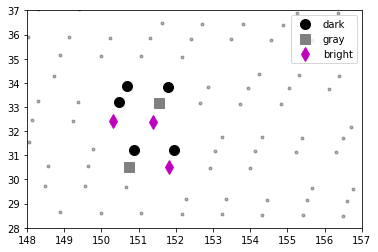

In [6]:
#- Plot those tiles
clf()
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.3, label='_none_')
isdark = tiles['PROGRAM'] == 'DARK'
isgray = tiles['PROGRAM'] == 'GRAY'
isbright = tiles['PROGRAM'] == 'BRIGHT'
plot(tiles['RA'][isdark], tiles['DEC'][isdark], 'o', color='k', ms=10, label='dark')
plot(tiles['RA'][isgray], tiles['DEC'][isgray], 's', color='0.5', ms=10, label='gray')
plot(tiles['RA'][isbright], tiles['DEC'][isbright], 'd', color='m', ms=10, label='bright')
xlim(148, 157); ylim(28, 37)
legend()

## Run survey simulations on the subset of tiles

This will select a test subset of tiles in the NGC and run survey simulations for observations during March 2020.  These steps should take <5 minutes to run.

In [7]:
orig_configfile = os.path.join(minitestdir, 'desisurvey-config.yaml')
configfile = os.path.join(surveydir, 'desisurvey-config.yaml')
shutil.copy(orig_configfile, configfile)

if os.path.exists(surveydir + '/surveyinit.fits'):
    print('surveyinit.fits already exists; skipping surveyinit')
else:
    logfilename = os.path.join(surveydir, 'surveyinit.log')
    cmd = 'surveyinit --config-file {}'.format(configfile)
    print('Running {}'.format(cmd))
    print('Starting at {}; should take ~2 minutes'.format(time.asctime()))
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('surveyinit failed err={}; see {}'.format(err, logfilename))
            raise RuntimeError
        else:
            print('done at {}'.format(time.asctime()))

surveyinit.fits already exists; skipping surveyinit


In [8]:
surveysim_expfile = os.path.join(surveydir, 'exposures_surveysim.fits')
if os.path.exists(surveysim_expfile):
    print('Survey sims already done; skipping')
else:
    logfilename = os.path.join(surveydir, 'surveysim.log')
    cmd = 'surveysim --config-file {} --save-restore'.format(configfile)
    print('Running {}'.format(cmd))
    print('Starting at {}; should take a few seconds'.format(time.asctime()))
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('surveysim failed err={}; see {}'.format(err, logfilename))
            raise RuntimeError
        else:
            print('done at {}'.format(time.asctime()))

Running surveysim --config-file /global/cscratch1/sd/sjbailey/minitest-19.12/survey/desisurvey-config.yaml --save-restore
Starting at Fri Dec 27 09:03:30 2019; should take a few seconds
done at Fri Dec 27 09:07:03 2019


### Confirm that we got the expected output files before proceeding

In [9]:
if not os.path.exists(surveysim_expfile):
    print("ERROR: Missing {}".format(expfile))
    print("Check {} for what might have gone wrong".format(survey_logname))
    print()
    
print('Files in {}:\n'.format(surveydir))
!ls $surveydir

Files in /global/cscratch1/sd/sjbailey/minitest-19.12/survey:

desisurvey-config.yaml		  scheduler_2020-03-16.fits
ephem_2019-01-01_2025-12-31.fits  scheduler_2020-03-17.fits
exposures_surveysim.fits	  scheduler_2020-03-18.fits
planner_2020-03-15.fits		  scheduler_2020-03-19.fits
planner_2020-03-16.fits		  scheduler_2020-03-20.fits
planner_2020-03-17.fits		  scheduler_2020-03-21.fits
planner_2020-03-18.fits		  scheduler_2020-03-22.fits
planner_2020-03-19.fits		  scheduler_2020-03-23.fits
planner_2020-03-20.fits		  scheduler_2020-03-24.fits
planner_2020-03-21.fits		  scheduler_2020-03-25.fits
planner_2020-03-22.fits		  scheduler_2020-03-26.fits
planner_2020-03-23.fits		  scheduler_2020-03-27.fits
planner_2020-03-24.fits		  scheduler_2020-03-28.fits
planner_2020-03-25.fits		  scheduler_2020-03-29.fits
planner_2020-03-26.fits		  scheduler_2020-03-30.fits
planner_2020-03-27.fits		  scheduler_2020-03-31.fits
planner_2020-03-28.fits		  scheduler_2020-04-01.fits
planner_2020-03-29.fits		  sch

### Add calibration exposures and extra columns from tiles table

In [10]:
expfile = os.path.join(surveydir, 'exposures.fits')
explist_lite = Table.read(surveysim_expfile, 'EXPOSURES')
explist = surveysim.util.add_calibration_exposures(explist_lite)

INFO:tiles.py:288:get_tiles: Initialized tiles from "desi-tiles.fits".
INFO:tiles.py:293:get_tiles: DARK   passes(tiles): 0(2010), 1(2011), 2(2007), 3(2010).
INFO:tiles.py:293:get_tiles: GRAY   passes(tiles): 4(2005).
INFO:tiles.py:293:get_tiles: BRIGHT passes(tiles): 5(2007), 6(2011), 7(2010).
INFO:util.py:129:add_calibration_exposures: Added 4 nightly calibration sequences of 6 exposures each to 21 science exposures.


In [11]:
print(explist_lite.colnames)
print(explist.colnames)

['MJD', 'EXPTIME', 'TILEID', 'SNR2FRAC', 'AIRMASS', 'SEEING', 'TRANSP', 'SKY']
['EXPID', 'MJD', 'EXPTIME', 'TILEID', 'SNR2FRAC', 'AIRMASS', 'SEEING', 'TRANSP', 'SKY', 'PROGRAM', 'NIGHT', 'FLAVOR', 'MOONFRAC', 'MOONALT', 'MOONSEP']


The default MOONALT, MOONSEP, and MOONFRAC columns are data model placeholders
but not filled in with meaningful values.  Correct that.  Notes:
* the code below is approximate (but still better than using MOONALT=-10 for BRIGHT exposures)
* surveysim doesn't currently vary the bright exposure time for lunar parameters (!), so filling
  this in with actual parameters instead of median defaults is arguably the wrong thing to do,
  but it does give us a variation of conditions from which one could how the exposure times
  should vary.

In [12]:
import desisurvey.ephem
import warnings
warnings.filterwarnings('ignore', message=r'Tried to get polar motions for times after IERS data')

def add_moon_params(explist):
    '''Fills MOONFRAC, MOONALT, MOONSEP columns in explist'''    

    ephem_file = glob.glob(surveydir + '/ephem*.fits')[0]
    ephem = Table.read(ephem_file)
    
    explist['MOONFRAC'] = np.interp(explist['MJD'], ephem['brightdusk'], ephem['moon_illum_frac'])

    ii = np.searchsorted(ephem['brightdusk'], explist['MJD'])-1
    assert np.all(ii>=0)
    for i, j in zip(ii, range(len(explist['MJD']))):
        if explist['FLAVOR'][j] != 'science':
            continue
        moon = desisurvey.ephem.get_object_interpolator(ephem[i], 'moon', altaz=True)
        mjd = explist['MJD'][j]
        explist['MOONALT'][j] = moon(mjd)[0]
        moon_dec, moon_ra = desisurvey.ephem.get_object_interpolator(ephem[i], 'moon', altaz=False)(mjd)        
        phi1, phi2 = np.radians(moon_dec), np.radians(explist['DEC'][j])
        theta1, theta2 = np.radians(moon_ra), np.radians(explist['RA'][j])
        #- Haversine formula
        d = 2*np.arcsin(np.sqrt(np.sin(0.5*(phi2-phi1))**2 + np.cos(phi1)*np.cos(phi2)*np.sin(0.5*(theta2-theta1))**2))
        # print(np.degrees([phi1, phi2, theta1, theta2]), np.degrees(d))
        explist['MOONSEP'][j] = np.degrees(d)

In [13]:
#- Prevent astropy from crashing because it can't download the latest IERS data
#- to calculate the location of the moon to sub-arcsecond accuracy (!)
from astropy.utils.iers import conf
conf.auto_max_age = None

expfile = os.path.join(surveydir, 'exposures.fits')
if os.path.exists(expfile):
    print('Reading explist from '+expfile)
    explist = Table.read(expfile)
else:
    print('Adding calibration exposures and additional columns to '+surveysim_expfile)
    explist = Table.read(surveysim_expfile, 'EXPOSURES')
    explist = surveysim.util.add_calibration_exposures(explist)
    explist = join(explist, tiles['TILEID', 'RA', 'DEC', 'PASS'], keys='TILEID', join_type='left')
    explist.sort('MJD')

    add_moon_params(explist)

    print('Writing explist to '+expfile)
    explist.meta['EXTNAME'] = 'EXPOSURES'
    explist.write(surveydir+'/exposures.fits', overwrite=True)

Adding calibration exposures and additional columns to /global/cscratch1/sd/sjbailey/minitest-19.12/survey/exposures_surveysim.fits
INFO:util.py:129:add_calibration_exposures: Added 4 nightly calibration sequences of 6 exposures each to 21 science exposures.
Writing explist to /global/cscratch1/sd/sjbailey/minitest-19.12/survey/exposures.fits


In [14]:
explist[explist['FLAVOR'] == 'science']

<Table masked=True length=21>
EXPID        MJD         EXPTIME TILEID ...         RA           DEC    PASS
int32      float64       float32 int32  ...      float64       float64 int16
----- ------------------ ------- ------ ... ------------------ ------- -----
    6 58924.112499999996  1080.0   1165 ...             150.69   33.86     0
    7  58924.12569444422   520.0   1165 ...             150.69   33.86     0
    8 58924.360532407816   590.0  24227 ...             151.56   33.18     4
    9 58924.368055555846   790.0  24227 ...             151.56   33.18     4
   10  58924.37858796309   620.0  28408 ... 150.73000000000002   30.52     4
   11 58924.386458333334   940.0  28408 ... 150.73000000000002   30.52     4
   18 58926.112499999996   880.0  11108 ...             150.87   31.23     1
   19  58926.12337962945   650.0  11108 ...             150.87   31.23     1
   20  58926.13229166635   670.0   6927 ... 151.77999999999997   33.84     1
   21  58926.14074074029   540.0   6927 ... 151.77999999999997   33.84     1
   28 58928.112499999996   480.0  18465 ... 150.47000000000003    33.2     3
   29  58928.11944444434   810.0  18465 ... 150.47000000000003    33.2     3
   30  58928.12951388862   760.0  18465 ... 150.47000000000003    33.2     3
   31  58928.13969907365   670.0  16870 ... 151.96000000000004   31.21     2
   32 58928.148148147586   980.0  16870 ... 151.96000000000004   31.21     2
   39  58951.26840277824   360.0  34170 ...             151.82    30.5     5
   40  58951.27395833372   260.0  34170 ...             151.82    30.5     5
   41  58951.27835648181   380.0  45704 ... 151.39999999999998   32.39     7
   42 58951.283449074326   280.0  45704 ... 151.39999999999998   32.39     7
   43 58951.288078703896   300.0  39942 ...             150.31   32.41     6
   44   58951.2922453705   410.0  39942 ...             150.31   32.41     6

## Study which healpixels cover those tiles

In [15]:
isbright = explist['PROGRAM'] == 'BRIGHT'
isgray = explist['PROGRAM'] == 'GRAY'
isdark = explist['PROGRAM'] == 'DARK'

(28, 37)

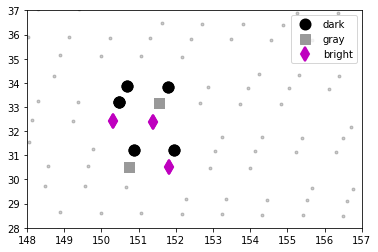

In [16]:
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.2, label='_none_')
plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
plot(explist['RA'][isgray], explist['DEC'][isgray], 's', color='0.6', ms=10, label='gray')
plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', color='m', ms=10, mew=2, label='bright')
legend(loc='upper right')
xlim(148, 157); ylim(28, 37)

In [17]:
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, tiles)
nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
print('{} tiles covered by {} exposures and {} healpixels'.format(len(tiles), nexp, len(pixels)))

10 tiles covered by 21 exposures and 46 healpixels


In [18]:
pixels

array([5261, 5262, 5263, 5272, 5273, 5274, 5275, 5278, 5281, 5283, 5284,
       5285, 5286, 5287, 5289, 5292, 5293, 5294, 5295, 5296, 5297, 5298,
       5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309,
       5310, 5311, 5346, 5352, 5354, 5637, 5648, 5649, 5650, 5651, 5652,
       5653, 5654])

(28, 37)

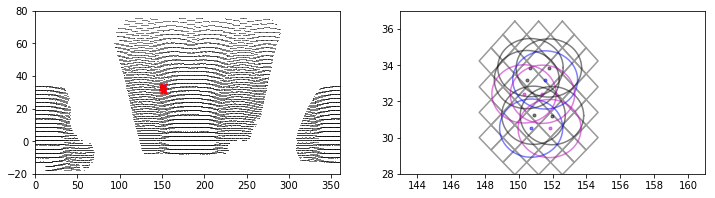

In [19]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color, alpha=0.5)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

figure(figsize=(12,3))
subplot(121)
plot(alltiles['RA'], alltiles['DEC'], 'k,', alpha=0.5)
plot(explist['RA'], explist['DEC'], 'b.', alpha=0.5)
plot(tiles['RA'], tiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = tiles['PROGRAM'] == program
    for t in tiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(143, 161); ylim(28, 37)

## Number of tiles observed per night

In [20]:
isDarkExp = (explist['PROGRAM'] == 'DARK')
isGrayExp = (explist['PROGRAM'] == 'GRAY')
isBrightExp = (explist['PROGRAM'] == 'BRIGHT')

print('NIGHT     DARK GRAY BRIGHT')
# print('20200315   2  4  0')

for night in sorted(set(explist['NIGHT'])):
    ii = (explist['NIGHT'] == night)
    ndark = len(set(explist['TILEID'][ii & isDarkExp]))
    ngray = len(set(explist['TILEID'][ii & isGrayExp]))
    nbright = len(set(explist['TILEID'][ii & isBrightExp]))
    print('{} {:4d} {:4d} {:4d}'.format(night, ndark, ngray, nbright))
    

NIGHT     DARK GRAY BRIGHT
20200315    1    2    0
20200317    2    0    0
20200319    2    0    0
20200411    0    0    3


## Run select_mock_targets

This step combines mock catalogs with spectral templates per covered healpixel.
This notebook prints the commands to run in a separate cori login terminal to
get a 15 node interactive job, and then run the `mpi_select_mock_targets` command.
It should take ~15 minutes on 15 nodes.

In [21]:
def is_select_mock_targets_done(targetdir, pixels, verbose=False):
    done = True
    filenames = glob.glob(os.path.join(targetdir, '*', '*', 'sky-*.fits'))
    if verbose:
        print('{}/{} sky files'.format(len(filenames), len(pixels)))
    if len(filenames) != len(pixels):
        done = False

    for obscon in ['dark', 'bright']:
        for filetype in ['target', 'truth']:
            filenames = glob.glob(os.path.join(targetdir, '*', '*', obscon, '{}*.fits'.format(filetype)))
            if verbose:
                print('{}/{} {} {} files'.format(len(filenames), len(pixels), obscon, filetype))
            if len(filenames) != len(pixels):
                done = False
    return done

is_select_mock_targets_done(targetdir, pixels, verbose=True)

0/46 sky files
0/46 dark target files
0/46 dark truth files
0/46 bright target files
0/46 bright truth files


False

In [22]:
if is_select_mock_targets_done(targetdir, pixels):
    print("mpi_select_mock_targets already successfully run; skipping")
else:
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    # configfile = os.path.join(os.getenv('DESITARGET'), 'doc', 'mock_example', 'input.yaml')

    tilefile = os.path.join(surveydir, 'test-tiles.fits')
    assert os.path.exists(tilefile)

    #- Copy config file to output location for archiving
    import pkg_resources
    refconfig = pkg_resources.resource_filename('desitarget', 'mock/data/select-mock-targets.yaml')
    assert os.path.exists(refconfig)
    configfile = targetdir+'/select-mock-targets.yaml'
    shutil.copy(refconfig, configfile)

    #- select_mock_targets maxes out at nproc=2**(128/nside) = 4 for nside=64
    #- calculate how many nodes to request
    npixels = len(pixels)
    nodes = int((npixels*4 - 1) // 32 + 1)
    
    cmd = "srun -A desi -N {nodes} -n {npixels} -c 8"  # -c 8 not 4 for hyperthreading
    cmd += " -C haswell -t 01:00:00 --qos interactive"
    cmd += " mpi_select_mock_targets --output_dir {targetdir} --config {configfile}"
    cmd += " --seed 1 --nproc 4 --nside 64 --tiles {tilefile}"
    cmd = cmd.format(nodes=nodes, npixels=npixels, targetdir=targetdir, tilefile=tilefile, configfile=configfile)
    
    print('Running mpi_select_mock_targets batch job; this should take ~15 minutes.')
    print("Starting at {}".format(time.asctime()))
    print(cmd)
    print('Logging to {}'.format(logfilename))
    
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('mpi_select_mock_targets failed err={}; see {}'.format(err, logfilename))
        else:
            print('done at {}'.format(time.asctime()))

Running mpi_select_mock_targets batch job; this should take ~15 minutes.
Starting at Fri Dec 27 09:07:09 2019
srun -A desi -N 6 -n 46 -c 8 -C haswell -t 01:00:00 --qos interactive mpi_select_mock_targets --output_dir /global/cscratch1/sd/sjbailey/minitest-19.12/targets --config /global/cscratch1/sd/sjbailey/minitest-19.12/targets/select-mock-targets.yaml --seed 1 --nproc 4 --nside 64 --tiles /global/cscratch1/sd/sjbailey/minitest-19.12/survey/test-tiles.fits
Logging to /global/cscratch1/sd/sjbailey/minitest-19.12/targets/select_mock_targets.log
done at Fri Dec 27 09:36:09 2019


## Check that we got the right number of target output files ##
The number of files of each type should match the number of healpixels

In [23]:
if is_select_mock_targets_done(targetdir, pixels, verbose=True):
    print('Success')
else:
    print('ERROR: missing files')
    print('Check {}'.format(logfilename))
    raise RuntimeError

46/46 sky files
46/46 dark target files
46/46 dark truth files
46/46 bright target files
46/46 bright truth files
Success


## Merge target, sky, and stdstar catalogs

mpi_select_mock_targets writes targets per healpixel.  This step combines them into full catalogs (but the truth spectra themselves are still kept in individual healpix-organized files, otherwise they would be too big).
It also generates the "Merged Target List" (mtl) that assigns priorities to targets for fiberassignment.
This step is fast so is spawned directly from the notebook without requiring a batch job.

In [24]:
need_target_join = False
for filename in ['targets-dark.fits', 'targets-bright.fits',
                 'truth-dark.fits', 'truth-bright.fits',
                 'mtl-dark.fits', 'mtl-bright.fits',
                 'sky.fits']:
    if not os.path.exists(targetdir + '/' + filename):
        need_target_join = True
        break

if need_target_join:
    cmd = "join_mock_targets --mockdir {} --overwrite".format(targetdir)
    print(cmd)
    err = subprocess.call(cmd.split())
    if err != 0:
        print('join_mock_targets failed err={}'.format(err))
    else:
        print('success')
else:
    print('join_mock_targets already run; skipping')

join_mock_targets --mockdir /global/cscratch1/sd/sjbailey/minitest-19.12/targets --overwrite
success


### Do some sanity checks on the results

In [25]:
targets, target_hdr = fitsio.read(os.path.join(targetdir, 'targets-dark.fits'), header=True)
mtl, mtl_hdr = fitsio.read(os.path.join(targetdir, 'mtl-dark.fits'), header=True)
truth   = fitsio.read(os.path.join(targetdir, 'truth-dark.fits'))
sky     = fitsio.read(os.path.join(targetdir, 'sky.fits'))

isStd = (mtl['DESI_TARGET'] & desi_mask.mask('STD_FAINT')) != 0
std = mtl[isStd]

In [26]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


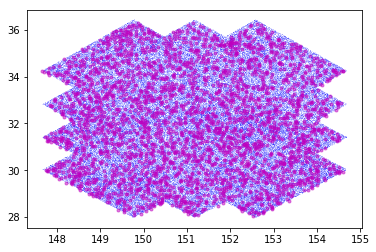

In [27]:
figure(figsize=(6,4))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.', alpha=0.5)

Text(0.5,0,'STD density [deg$^{-2}$]')

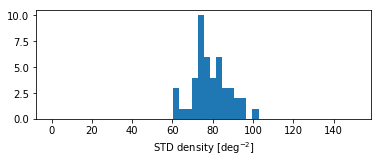

In [28]:
import collections
nstd = np.array(list(collections.Counter(std['HPXPIXEL']).values()))
figure(figsize=(6,2))
hist(nstd / hp.nside2pixarea(64, degrees=True), 50, (0,151))
xlabel('STD density [deg$^{-2}$]')

In [29]:
npix = len(set(std['HPXPIXEL']))
pixarea = hp.nside2pixarea(64, degrees=True)
len(std)/(npix*pixarea)

78.58575138208718

## Run target selection QA

In [30]:
targetfile = os.path.join(targetdir, 'targets-dark.fits')
targetQAdir = os.path.join(targetdir, 'qa')
targetQAlog = os.path.join(targetQAdir, 'target-qa.log')
os.makedirs(targetQAdir, exist_ok=True)

if not os.path.exists(targetQAdir+'/skymap-ALL.png'):
    cmd = 'run_target_qa {} {} --mocks --nside 64 --nosystematics'.format(targetfile, targetQAdir)
    with open(targetQAlog, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)

    if err != 0:
        print('ERROR running {}'.format(cmd))
        msg = 'see {}'.format(targetQAlog)
        raise RuntimeError(msg)
else:
    print('Target QA already done; skipping')

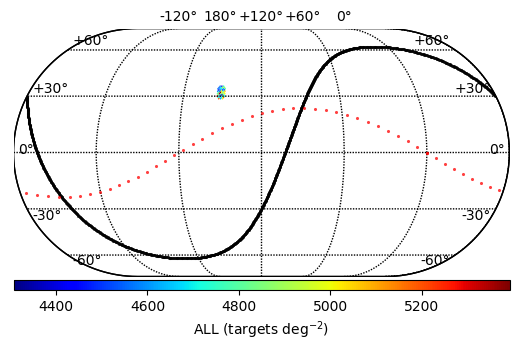

In [31]:
from IPython.display import Image, display, HTML
Image(targetQAdir+'/skymap-ALL.png', width=500)

In [32]:
def rowplot_images(imagefiles):
    x = ''.join( ["<img style='width: 300px; margin: 0px; float: left;' src='%s' />" % str(s) 
                 for s in imagefiles ])
    display(HTML(x))


targtypes = ['ELG', 'LRG', 'QSO']
qafiles = ['{}/histo-{}.png'.format(targetQAdir, tt) for tt in targtypes]
rowplot_images(qafiles)

targtypes = ['BGS_ANY', 'MWS_ANY']
qafiles = ['{}/histo-{}.png'.format(targetQAdir, tt) for tt in targtypes]
rowplot_images(qafiles)

## Run fiberassign

In [33]:
def is_fiberassign_done(fibassigndir, tiles, verbose=False):
    done = True
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'fiberassign-{:06d}.fits'.format(tileid))
        if not os.path.exists(tilefile):
            done = False
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

is_fiberassign_done(fibassigndir, tiles)

False

In [34]:
if is_fiberassign_done(fibassigndir, tiles):
    print('fiberassign already done; skipping')
else:
    print('Generating lists of dark and bright tiles')
    #- Write list of tiles to consider
    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
    for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
        if program == 'BRIGHT':
            bx.write(str(tileid)+'\n')
        else:
            dx.write(str(tileid)+'\n')

    dx.close()
    bx.close()

    #- Remove any leftover tile files
    for tilefile in glob.glob(fibassigndir+'/tile_*.fits'):
        os.remove(tilefile)
        
    #- cp fiberstatus.ecsv example file into output area for archiving
    shutil.copy(minitestdir+'/fiberstatus.ecsv', fibassigndir+'/fiberstatus.ecsv')

    cmd = "fiberassign --overwrite"
    cmd += " --mtl {}/mtl-{{program}}.fits".format(targetdir)
    ## cmd += " --stdstar {}/{{stdfile}}".format(targetdir)
    cmd += " --sky {}/sky.fits".format(targetdir)
    cmd += " --surveytiles {}/{{tilefile}}".format(fibassigndir)
    ## cmd += " --fibstatusfile {}/fiberstatus.ecsv".format(fibassigndir)
    cmd += " --outdir {}/{{program}}".format(fibassigndir)

    #- Run fiberassign
    success = True
    for program in ['dark', 'bright']:
        logfilename = os.path.join(fibassigndir, 'fiberassign-{}.log'.format(program))
        print('logging to {}'.format(logfilename))
        with open(logfilename, 'a') as logfile:
            stdfile = 'standards-{}.fits'.format(program)
            tilefile = '{}-tiles.txt'.format(program)
            cmdx = cmd.format(stdfile=stdfile, tilefile=tilefile, program=program)
            print('RUNNING', cmdx)
            err = subprocess.call(cmdx.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                success = False
                print('\nfiberassign failed err={}; see {}\n'.format(err, logfilename))
    
    #- Move the tile files into their final location
    for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
        if program == 'GRAY':
            program = 'DARK'  #- dark and gray tiles are grouped together

        filename = '{}/{}/fiberassign-{:06d}.fits'.format(fibassigndir, program.lower(), tileid)
        shutil.move(filename, fibassigndir)

    if not success:
        raise RuntimeError('ERROR: fiberassign exited with non-zero error code')
        
    if is_fiberassign_done(fibassigndir, tiles, verbose=True):
        print('SUCCESS')
    else:
        raise RuntimeError('ERROR: missing fiberassign output files')
        

Generating lists of dark and bright tiles
logging to /global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/fiberassign-dark.log
RUNNING fiberassign --overwrite --mtl /global/cscratch1/sd/sjbailey/minitest-19.12/targets/mtl-dark.fits --sky /global/cscratch1/sd/sjbailey/minitest-19.12/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/dark-tiles.txt --outdir /global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/dark
logging to /global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/fiberassign-bright.log
RUNNING fiberassign --overwrite --mtl /global/cscratch1/sd/sjbailey/minitest-19.12/targets/mtl-bright.fits --sky /global/cscratch1/sd/sjbailey/minitest-19.12/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/bright-tiles.txt --outdir /global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/bright
SUCCESS


### Run fiberassign QA ###
This will find non-fatal errors with unassigned fibers and too few standards

**TODO**: are errors real, or problems with qa-fiberassign?

In [35]:
!qa-fiberassign --verbose --targets $targetdir/targets-dark.fits $fibassigndir/fiberassign-*.fits 

/global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/fiberassign-001165.fits - ERROR
    9 unassigned good fibers
    Fibers assigned to more than 6mm from positioner center
    0 stuck, 0 broken, 400 sky, 100 stdstars
/global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/fiberassign-006927.fits - ERROR
    9 unassigned good fibers
    Fibers assigned to more than 6mm from positioner center
    0 stuck, 0 broken, 400 sky, 100 stdstars
/global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/fiberassign-011108.fits - ERROR
    7 unassigned good fibers
    Fibers assigned to more than 6mm from positioner center
    0 stuck, 0 broken, 401 sky, 100 stdstars
/global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/fiberassign-016870.fits - ERROR
    9 unassigned good fibers
    Fibers assigned to more than 6mm from positioner center
    0 stuck, 0 broken, 400 sky, 100 stdstars
/global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign/fiberassign-018465.fits - ERROR
    6 unassigned go

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but then run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

4.4 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes.

In [36]:
def is_newexp_done(explist, simdatadir, verbose=False):
    numnights = len(set(explist['NIGHT']))
    nexp = len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles = glob.glob(os.path.join(simdatadir, '*', '*', 'simspec*.fits'))
    fibermapfiles = glob.glob(os.path.join(simdatadir, '*', '*', 'fibermap*.fits'))
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    elif len(fibermapfiles) != nexp:
        return False
    else:
        return True

# is_newexp_done(explist, simdatadir, verbose=True)

In [37]:
if is_newexp_done(explist, simdatadir):
    print('newexp already done; skipping')
else:
    logfilename = os.path.join(simdatadir, 'newexp.log')

    tilefile = os.path.join(surveydir, 'test-tiles.fits')
    assert os.path.exists(tilefile)

    nodes = 15
    cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
    cmd += " -C haswell -t 00:15:00 --qos interactive"
    cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
    cmd += " --mockdir {}".format(targetdir)
    cmd += " --obslist {}/exposures.fits".format(surveydir)
    cmd += " --tilefile {}".format(tilefile)

    print('Running wrap-newexp batch job; should take ~5 min')
    print('Starting at {}'.format(time.asctime()))
    print(cmd)
    print('Logging to {}'.format(logfilename))
    
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('\nERROR {} running wrap-newexp; see {}'.format(err, logfilename))
        else:
            print('done')


Running wrap-newexp batch job; should take ~5 min
Starting at Fri Dec 27 09:40:33 2019
srun -A desi -N 15 -n 15 -c 32 -C haswell -t 00:15:00 --qos interactive wrap-newexp --mpi --fiberassign /global/cscratch1/sd/sjbailey/minitest-19.12/fiberassign --mockdir /global/cscratch1/sd/sjbailey/minitest-19.12/targets --obslist /global/cscratch1/sd/sjbailey/minitest-19.12/survey/exposures.fits --tilefile /global/cscratch1/sd/sjbailey/minitest-19.12/survey/test-tiles.fits
Logging to /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/sim/mini/newexp.log
done


### Confirm that we got the expected newexp output files

In [38]:
if is_newexp_done(explist, simdatadir, verbose=True):
    print('Success')
else:
    print('ERROR: Missing files')
    raise RuntimeError

45/45 simspec files
45/45 fibermap files
Success


## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

6.3 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes

In [39]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    nflat = np.count_nonzero(explist['FLAVOR'] == 'flat')
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    nframe = 30*(nflat + nscience)
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')
    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return False
    else:
        return True

is_fastframe_done(explist, reduxdir, verbose=True)

0/990 frame files


False

In [40]:
if is_fastframe_done(explist, reduxdir, verbose=True):
    print('fastframe already done; skipping')
else:
    logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
    os.makedirs(os.path.dirname(logfilename), exist_ok=True)
    print('Running fastframe batch job')
    print('Starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    nodes = 15

    cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 -C haswell -t 00:45:00 --qos interactive".format(nodes=nodes)
    cmd += " wrap-fastframe --mpi"
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
        else:
            print('done at {}'.format(time.asctime()))

if is_fastframe_done(explist, reduxdir, verbose=True):
    print('SUCCESS')
else:
    print('ERROR; see {}'.format(logfilename))
    raise RuntimeError

0/990 frame files
Running fastframe batch job
Starting at Fri Dec 27 09:49:57 2019
Logging to /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/exposures/fastframe.log
done at Fri Dec 27 10:26:18 2019
990/990 frame files
SUCCESS


In [41]:
#- Check individual framefile outputs
ntot = 0
nbad = 0
for night, expid, flavor in explist['NIGHT', 'EXPID', 'FLAVOR']:
    if flavor != 'flat' and flavor != 'science':
        continue

    for channel in ['b', 'r', 'z']:
        for spectrograph in range(10):
            camera = channel + str(spectrograph)
            framefile = desispec.io.findfile('frame', night, expid, camera)
            ntot += 1
            if not os.path.exists(framefile):
                nbad += 1
                print('Missing {} frame {}'.format(flavor, framefile))

if nbad > 0:
    print('Missing {}/{} frame files'.format(nbad, ntot))
else:
    print('All {} science and flat frame files generated'.format(ntot))

All 990 science and flat frame files generated


## Run the spectro pipeline

### First, create the production database.

In [42]:
pipe_setup_file = desispec.io.specprod_root() + '/setup.sh'

if not os.path.exists(pipe_setup_file):
    print('creating production database and setup script')
    cmd = "desi_pipe create --db-postgres --force"
    cmd += " --data {}".format(os.getenv('DESI_SPECTRO_DATA'))
    cmd += " --redux {}".format(os.getenv('DESI_SPECTRO_REDUX'))
    cmd += " --prod {}".format(os.getenv('SPECPROD'))
    print(cmd)
    err = subprocess.call(cmd.split())
    assert err == 0
    # assert os.path.exists(desispec.io.get_pipe_database())
    print('SUCCESS')
else:
    print(pipe_setup_file)
    print('spectro pipeline setup file already exists; skipping')


creating production database and setup script
desi_pipe create --db-postgres --force --data /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/sim/mini --redux /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux --prod mini
SUCCESS


### Read the pipeline setup.sh file to get the postgres DB location
From the command line we would just source this file, but here we need the jupyter
notebook to have that environment, thus the parsing.  `$DESI_SPECTRO_REDUX` and `$SPECPROD`
are evaluated within the setup.sh file itself, so handle those separately

In [43]:
os.environ['DESI_SPECTRO_REDUX'] = os.path.dirname(reduxdir)
os.environ['SPECPROD'] = os.path.basename(reduxdir)

In [44]:

with open(pipe_setup_file) as fx:
    for line in fx:
        line = line.strip()
        if line.startswith('export '):
            keyvalue = line.split(' ')[1]
            key, value = keyvalue.split('=', maxsplit=1)
            if key in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
                continue
            if key in os.environ and value != os.environ[key]:
                print('{} {} -> {}'.format(key, os.environ[key], value))
            elif key not in os.environ:
                print('Setting {}={}'.format(key, value))
            
            os.environ[key] = value

Setting DESI_SPECTRO_DB=postgresql:nerscdb03.nersc.gov:5432:desidev:desidev_admin:pipe_afbb7630fbb7338e7bcdd633c6bb5ab3


### Sync up with the actual files on disk

We didn't start with raw data files, so we'll skip over extraction and PSF-fitting steps.
`desi_pipe sync` will update the database from what files are actually on disk.

In [45]:
err        = subprocess.call('desi_pipe sync'.split())
assert err == 0
output     = subprocess.check_output('desi_pipe top --once'.split())
print(output.decode())

----------------+---------+---------+---------+---------+---------+---------+
   Task Type    | waiting | ready   | running | done    | failed  | submit  |
----------------+---------+---------+---------+---------+---------+---------+
preproc         |     1350|        0|        0|        0|        0|        0|
psf             |      360|        0|        0|        0|        0|        0|
psfnight        |      120|        0|        0|        0|        0|        0|
traceshift      |      990|        0|        0|        0|        0|        0|
extract         |        0|        0|        0|      990|        0|        0|
fiberflat       |        0|      360|        0|        0|        0|        0|
fiberflatnight  |      120|        0|        0|        0|        0|        0|
sky             |      630|        0|        0|        0|        0|        0|
starfit         |      210|        0|        0|        0|        0|        0|
fluxcalib       |      630|        0|        0|        0|       

### Run pipeline scripts as a series of interactive jobs

`desi_pipe chain` would be a more convenient way of doing this,
but for the minitest it takes too long to wait for N>>1 jobs in the debug queue,
so we'll wrap this with interactive queue batch jobs.

In [46]:
taskdir = os.path.join(desispec.io.get_pipe_rundir(), 'minitest')
os.makedirs(taskdir, exist_ok=True)

dbpath = desispec.io.get_pipe_database()
db = desispec.pipeline.load_db(dbpath, mode="w")

tasktypes = ['fiberflat', 'fiberflatnight', 'sky', 'starfit', 'fluxcalib', 'cframe', 'spectra', 'redshift']
for tasktype in tasktypes:
    for night in np.unique(explist['NIGHT']):
        db.getready(night)

    taskfile = "{}/{}.tasks".format(taskdir, tasktype)
    cmd = "desi_pipe tasks --tasktype {} --states ready,waiting ".format(tasktype)
    cmd += " > {}".format(taskfile)
    try:
        subprocess.check_call(cmd, shell=True)
    except subprocess.CalledProcessError:
        print('FAILED: {}'.format(cmd))
        break
    
    task_count = db.count_task_states(tasktype)
    if tasktype == 'redshift':
        ranks_per_task = 32
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task // 2  #- two iterations
        nodes = (n-1) // 32 + 1
        runtime = 59    #- minutes
    elif tasktype == 'spectra':
        ranks_per_task = 1
        cores_per_rank = 16
        n = task_count['ready'] * ranks_per_task
        runtime = 20    #- minutes
    elif tasktype == 'cframe':
        ranks_per_task = 1
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task
        runtime = 5     #- minutes

    else:
        ranks_per_task = 1
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task
        runtime = 15    #- minutes

    nodes = (n*cores_per_rank-1) // 64 + 1

    if n > 0:
        t0 = time.time()
        cmd = 'srun -A desi -t {}:00 -C haswell --qos interactive'.format(runtime)
        cmd += ' -N {nodes} -n {procs} -c {cores} '.format(nodes=nodes, procs=n, cores=cores_per_rank)
        cmd += ' desi_pipe_exec_mpi --tasktype {} --taskfile {}'.format(tasktype, taskfile)
        logfilename = '{}/{}.log'.format(taskdir, tasktype)
        print('Running {} {} tasks'.format(task_count['ready'], tasktype))
        print('Logging to {}'.format(logfilename))
        print(cmd)
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('    ERROR {} for tasktype {}'.format(err, tasktype))
                print('    See {}'.format(logfilename))
            else:
                dt = time.time() - t0
                print('  DONE at {}'.format(time.asctime()))
                print('  {} took {:.1f} min'.format(tasktype, dt/60))
    elif task_count['waiting'] == 0 and task_count['done'] > 0:
        print('All {} tasks already run'.format(tasktype))
    else:
        print('No {} tasks ready to run; skipping'.format(tasktype))

for night in np.unique(explist['NIGHT']):
    db.getready(night)

print(subprocess.check_output('desi_pipe top --once'.split()).decode())

Running 360 fiberflat tasks
Logging to /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/run/minitest/fiberflat.log
srun -A desi -t 15:00 -C haswell --qos interactive -N 12 -n 360 -c 2  desi_pipe_exec_mpi --tasktype fiberflat --taskfile /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/run/minitest/fiberflat.tasks
  DONE at Fri Dec 27 10:29:14 2019
  fiberflat took 2.3 min
Running 120 fiberflatnight tasks
Logging to /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/run/minitest/fiberflatnight.log
srun -A desi -t 15:00 -C haswell --qos interactive -N 4 -n 120 -c 2  desi_pipe_exec_mpi --tasktype fiberflatnight --taskfile /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/run/minitest/fiberflatnight.tasks
  DONE at Fri Dec 27 10:30:12 2019
  fiberflatnight took 0.9 min
Running 630 sky tasks
Logging to /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/run/minitest/sky.log
srun -A desi -t 15:00 -C haswell --qos interactive

### Check that we got expected outputs

In [47]:
def is_cframe_done(explist, reduxdir, verbose=False):
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    ncframe = 30*nscience
    cframefiles = glob.glob(reduxdir+'/exposures/*/*/cframe*.fits')
    if verbose:
        print('{}/{} cframe files'.format(len(cframefiles), ncframe))
    
    if len(cframefiles) != ncframe:
        return False
    else:
        return True

is_cframe_done(explist, reduxdir, verbose=True)

630/630 cframe files


True

In [48]:
if is_cframe_done(explist, reduxdir, verbose=True):
    print('All cframe files successfully generated')
else:
    print('ERROR: missing cframe files')
    raise RuntimeError

630/630 cframe files
All cframe files successfully generated


In [49]:
def is_regrouping_done(pixels, reduxdir):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra-*.fits')
    #- some pixels might not be covered by real data, but most should be
    if len(specfiles) < len(pixels) - 5:
        return False
    else:
        return True

is_regrouping_done(pixels, reduxdir)

True

## Did all pixels make it from sims -> output spectra?

tiles2pix may have been conservative and included some edge pixels that weren't
really necessary.

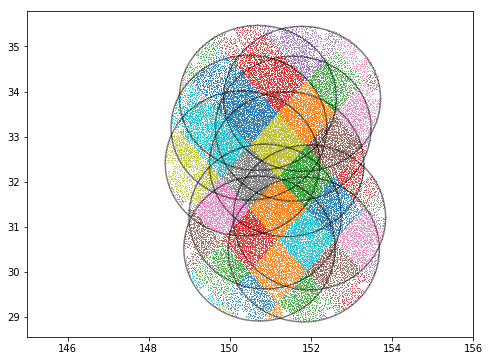

In [50]:
nside=64
misspix = list()
figure(figsize=(8,6))

for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))

    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['TARGET_RA'], fibermap['TARGET_DEC'], ',', alpha=0.5)

plot_healpix(nside, misspix)

for t in tiles:
    plot_tile(t['RA'], t['DEC'])

tmp = xlim(145, 156)

In [51]:
def is_redrock_done(reduxdir, verbose=False):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra*.fits')
    zbestfiles = glob.glob(reduxdir+'/spectra-*/*/*/zbest*.fits')
    if verbose:
        print('{}/{} zbest files'.format(len(zbestfiles), len(specfiles)))
    if len(zbestfiles) != len(specfiles):
        return False
    else:
        return True

if not is_redrock_done(reduxdir, verbose=True):
    raise RuntimeError("Missing redrock files")

46/46 zbest files


### Count number of spectra and targets per healpix

In [52]:
specdir   = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'], 'spectra-64')
specfiles = list()

for specfile in sorted(list(desitarget.io.iter_files(specdir, 'spectra'))):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm) * 3
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )

In [53]:
print('==================== ===== ========')
print('specfile             nspec ntargets')
print('==================== ===== ========')

for ntarg, nspec, specfile in sorted(specfiles):
    print("{0:20s} {1:5d} {2:8d}".format(os.path.basename(specfile), nspec, ntarg))

print('==================== ===== ========')

==================== ===== ========
specfile             nspec ntargets
==================== ===== ========
spectra-64-5289.fits    36        6
spectra-64-5301.fits    78       13
spectra-64-5281.fits   132       22
spectra-64-5261.fits   198       33
spectra-64-5294.fits   246       41
spectra-64-5650.fits   291       44
spectra-64-5654.fits   282       47
spectra-64-5354.fits   366       61
spectra-64-5273.fits   372       62
spectra-64-5346.fits   432       72
spectra-64-5283.fits   474       79
spectra-64-5262.fits   654      108
spectra-64-5653.fits   924      146
spectra-64-5278.fits   894      149
spectra-64-5272.fits  1056      176
spectra-64-5651.fits  1110      179
spectra-64-5352.fits  1284      214
spectra-64-5637.fits  1950      276
spectra-64-5292.fits  3732      617
spectra-64-5300.fits  4344      723
spectra-64-5284.fits  4440      734
spectra-64-5303.fits  5034      834
spectra-64-5263.fits  5274      872
spectra-64-5311.fits  5862      874
spectra-64-5652.fits  6510  

## Create zcatalog

This is just a merging of the individual zbest files

In [54]:
zcatfile = desispec.io.findfile('zcatalog')
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {zcatfile} --match {targetdir}/targets-dark.fits'.format(
        reduxdir=reduxdir, zcatfile=zcatfile, targetdir=targetdir)
print(cmd)
!$cmd

desi_zcatalog -i /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/zcatalog-mini.fits --match /global/cscratch1/sd/sjbailey/minitest-19.12/targets/targets-dark.fits
INFO:desi_zcatalog:148:<module>: matching /global/cscratch1/sd/sjbailey/minitest-19.12/targets/targets-dark.fits
INFO:desi_zcatalog:154:<module>: wrote /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/zcatalog-mini.fits


## Redshift QA

This section does some "by-hand" redshift QA, bypassing the standard spectro pipeline QA (see below).

In [55]:
from desisim.spec_qa import redshifts as dsq_z
import astropy.table
import numpy as np
from matplotlib.pyplot import hist
from astropy.table import Table

In [56]:
truth = Table.read(os.path.join(targetdir, 'truth-dark.fits'), 'TRUTH')
zcat = Table.read(zcatfile)

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

#- Add OIIFLUX by hand only for ELGs
truth_elg = Table.read(os.path.join(targetdir, 'truth-dark.fits'), 'TRUTH_ELG')
del truth_elg.meta['EXTNAME']
truth = astropy.table.join(truth, truth_elg, join_type='left')

In [57]:
truth_elg.colnames

['TARGETID',
 'OIIFLUX',
 'HBETAFLUX',
 'EWOII',
 'EWHBETA',
 'D4000',
 'VDISP',
 'OIIDOUBLET',
 'OIIIHBETA',
 'OIIHBETA',
 'NIIHBETA',
 'SIIHBETA',
 'TRUEZ_NORSD']

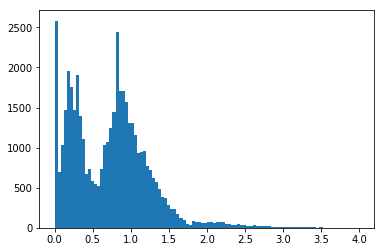

In [58]:
_ = hist(zcat['Z'], 100, (0, 4))

In [59]:
del zcat.meta['EXTNAME']
del truth.meta['EXTNAME']

ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [60]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')

print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  2804
LRG  5230
ELG  16474
STAR 3605
BGS  5813


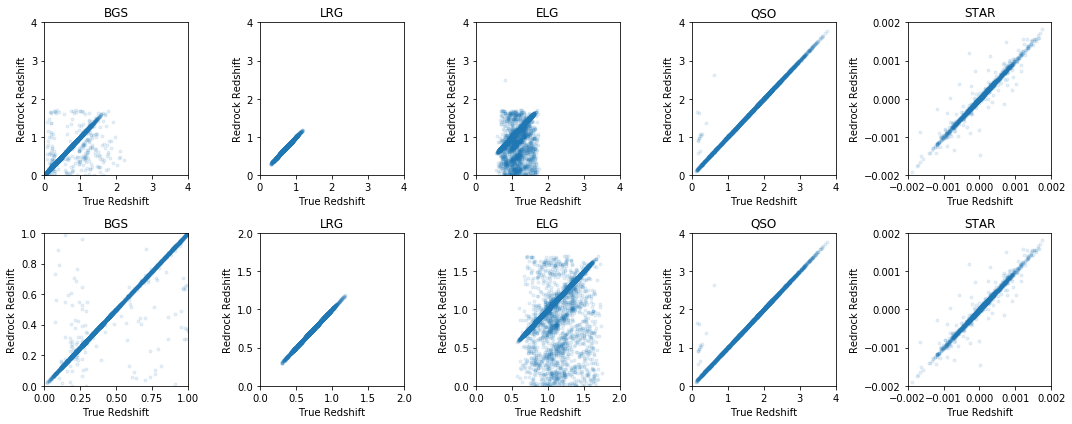

In [61]:
from matplotlib.pyplot import figure, subplot, plot, title, xlim, ylim, xlabel, ylabel, tight_layout

def plotz(ztruth, label, zmin=0.0, zmax=1.5):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)
    xlabel('True Redshift')
    ylabel('Redrock Redshift')

figure(figsize=(15,6))

subplot(251); plotz(ztruth[isBGS], 'BGS', zmax=4)
subplot(252); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(253); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(254); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(255); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)

subplot(256); plotz(ztruth[isBGS], 'BGS', zmax=1)
subplot(257); plotz(ztruth[isLRG], 'LRG', zmax=2)
subplot(258); plotz(ztruth[isELG], 'ELG', zmax=2)
subplot(259); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(2,5,10); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)

tight_layout()

In [62]:
# Merge the truth and zcat tables
# match_truth_z fails on the repeated TARGETID=-1 of unassigned fibers, so filter those out
assigned = zcat['TARGETID'] >= 0
dsq_z.match_truth_z(truth, zcat[assigned], mini_read=True)

In [63]:
print('          ntarg   good  fail  miss  lost')
for objtype in set(truth['TEMPLATETYPE']):
    #isx = (truth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost, nx = dsq_z.zstats(truth, objtype=objtype)
    #nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
BGS        3772   92.2   0.2   4.7   3.0
WD           90  100.0   0.0   0.0   0.0
QSO_T      3886   93.1   0.6   2.1   4.2
ELG       18095   78.5   0.6   9.1  11.8
LRG        5433  100.0   0.0   0.0   0.0
QSO_L       845   99.9   0.1   0.0   0.0
STAR       3605   92.3   0.4   1.9   5.4

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


## Spectral Classification Confusion Matrix

To be replaced with `desisim.spec_qa.redshifts.spectype_confusion` in a post-18.3 version.

In [64]:
#- Confusion matrix
specmix = dict()
spectypes = sorted(set(ztruth['TRUESPECTYPE']))

for s1 in spectypes:
    specmix[s1] = dict()
    for s2 in spectypes:
        n = np.count_nonzero((ztruth['TRUESPECTYPE']==s1) & (ztruth['SPECTYPE'] == s2))
        specmix[s1][s2] = n

In [65]:
#- Print header line
print('            Redrock')
print('Truth     ', end='')
for s1 in spectypes:
    print('{:>8s}'.format(s1), end='')
print()
    
for s1 in spectypes:
    print('{:8s}  '.format(s1), end='')
    for s2 in spectypes:
        print('{:8d}'.format(specmix[s1][s2]), end='')
    print()

            Redrock
Truth       GALAXY     QSO    STAR      WD
GALAXY       27514       1       2       0
QSO             14    2790       0       0
STAR           269       0    3336       0
WD               0       0      90       0


## Study target coverage

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'NUMEXP')

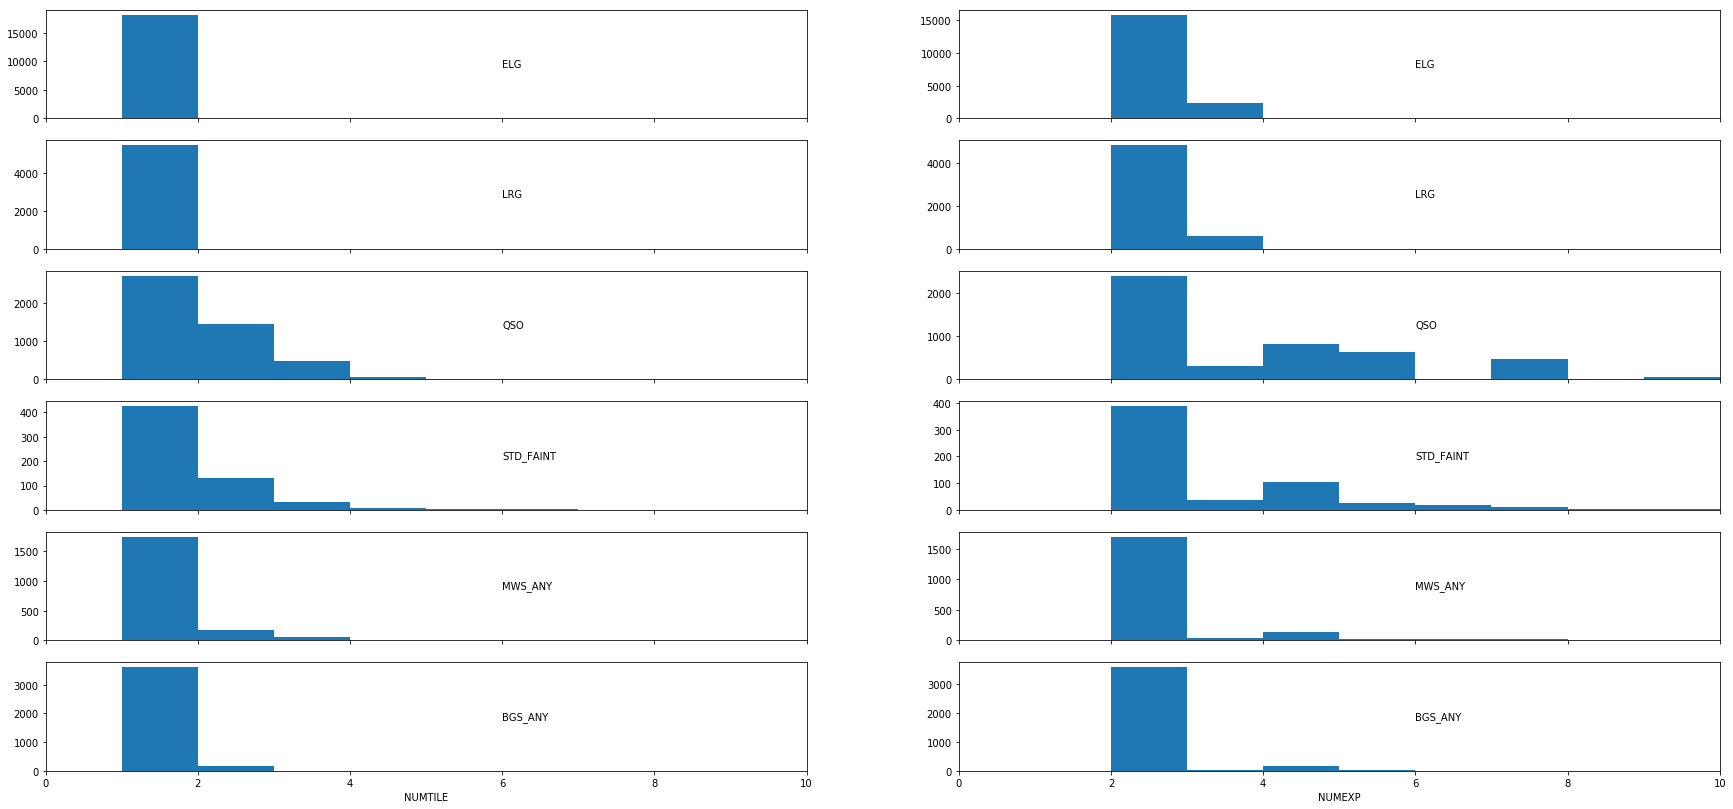

In [66]:
from desitarget.targetmask import desi_mask
from collections import Counter

figure(figsize=(30,14))

for i, targtype in enumerate(['ELG', 'LRG', 'QSO', 'STD_FAINT', 'MWS_ANY', 'BGS_ANY']):
    ii = (zcat['DESI_TARGET'] & desi_mask[targtype]) != 0
    subplot(6,2,1+2*i)
    n = hist(zcat['NUMTILE'][ii], 10, (0,10))[0]
    text(6, np.max(n)/2, targtype)
    xlim(0,10)
    if i<5:
        xticks([0,2,4,6,8,10], ['']*6)
    subplot(6,2,2+2*i)
    n = hist(zcat['NUMEXP'][ii], 10, (0,10))[0]
    text(6, np.max(n)/2, targtype)
    xlim(0,10)
    if i<5:
        xticks([0,2,4,6,8,10], ['']*6)

subplot(6,2,11); xlabel('NUMTILE')
subplot(6,2,12); xlabel('NUMEXP')

## Load the Spectro Catalog Database

Start by configuring the database, then load exposures, truth, targets, fiberassign, and the redshift catalog.

In [67]:
import importlib
import desispec.database.redshift

importlib.reload(desispec.database.redshift)

<module 'desispec.database.redshift' from '/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/desispec/0.32.1/lib/python3.6/site-packages/desispec-0.32.1-py3.6.egg/desispec/database/redshift.py'>

In [68]:
import os

from argparse                   import Namespace

from desispec.database.redshift import (setup_db, dbSession, load_file, ObsList, Target, Truth, ZCat, FiberAssign,
                                        load_fiberassign, update_truth)

options      = Namespace(overwrite=True, dbfile=os.path.join(basedir, 'minitest.db'), hostname=None, maxrows=2000,
                         chunksize=50000, schema=None, username=None, verbose=False, datapath=basedir)

# We'll be using a SQLite database, ignore the return value of setup_db.
postgresql = setup_db(options)

print(expfile)

print('--- Loading exposure list')
load_file(expfile, ObsList, hdu='EXPOSURES', expand={'PASS': 'passnum'})

print('--- Loading truth tables')
load_file(os.path.join(targetdir, 'truth-dark.fits'), Truth, hdu='TRUTH')

for h in ('BGS', 'ELG', 'LRG', 'QSO', 'STAR', 'WD'):
    update_truth(os.path.join(targetdir, 'truth-dark.fits'), 'TRUTH_' + h)

print('--- Loading targets')

load_file(os.path.join(targetdir, 'targets-dark.fits'), Target, hdu='TARGETS',
          expand={'DCHISQ': ('dchisq_psf', 'dchisq_rex', 'dchisq_dev', 'dchisq_exp', 'dchisq_comp',)})

print('--- loading redshift catalog')
load_file(os.path.join(reduxdir, 'zcatalog-mini.fits'), ZCat, hdu='ZCATALOG',
          expand={'COEFF': ('coeff_0', 'coeff_1', 'coeff_2', 'coeff_3', 'coeff_4',
                            'coeff_5', 'coeff_6', 'coeff_7', 'coeff_8', 'coeff_9',)},
          rowfilter=lambda x: ((x['TARGETID'] != 0) & (x['TARGETID'] != -1)))

print('--- loading fiber assignments')
load_fiberassign(fibassigndir)

print('--- done')

INFO:redshift.py:830:setup_db: Begin creating tables.
INFO:redshift.py:834:setup_db: Finished creating tables.
/global/cscratch1/sd/sjbailey/minitest-19.12/survey/exposures.fits
--- Loading exposure list
INFO:redshift.py:383:load_file: Read data from /global/cscratch1/sd/sjbailey/minitest-19.12/survey/exposures.fits HDU EXPOSURES
INFO:redshift.py:401:load_file: Integrity check complete on obslist.
INFO:redshift.py:409:load_file: Initial column conversion complete on obslist.
INFO:redshift.py:431:load_file: Column expansion complete on obslist.
INFO:redshift.py:437:load_file: Column conversion complete on obslist.
INFO:redshift.py:444:load_file: Converted columns into rows on obslist.
INFO:redshift.py:451:load_file: Inserted 45 rows in obslist.
--- Loading truth tables
INFO:redshift.py:383:load_file: Read data from /global/cscratch1/sd/sjbailey/minitest-19.12/targets/truth-dark.fits HDU TRUTH
INFO:redshift.py:401:load_file: Integrity check complete on truth.
INFO:redshift.py:409:load_fi

### Demonstrate the SQLAlchemy objects

In [69]:
tt = dbSession.query(Truth, Target).filter(Truth.targetid == Target.targetid).all()

In [70]:
zz = dbSession.query(Truth, ZCat).filter(Truth.targetid == ZCat.targetid).all()

In [71]:
ff = dbSession.query(Truth, FiberAssign).filter(Truth.targetid == FiberAssign.targetid).all()

In [72]:
# How many actual exposures are there with the Moon up?
q = dbSession.query(ObsList.expid, ObsList.moonsep, ObsList.moonalt, ObsList.moonfrac).filter(ObsList.moonalt > 0).all()
q

[(8, 122.44709475771212, 0.42488345946132045, 0.4860627058850807),
 (9, 122.53670459889443, 2.3616454543105827, 0.4852787587295292),
 (10, 122.95360969391353, 5.028193277131029, 0.48418123271160535),
 (11, 123.0440276920421, 6.983493291066839, 0.4833611033797137),
 (39, 116.34353638147344, 0.4001825648595744, 0.7545447815726879),
 (40, 116.41446917621921, 1.8375721269357053, 0.7540001078638929),
 (41, 117.19230298558917, 2.965627215753266, 0.7535689078439843),
 (42, 117.25566306308285, 4.2603465939951635, 0.7530696236114574),
 (43, 118.22121418015178, 5.426226448422642, 0.7526157288537715),
 (44, 118.27198428284888, 6.466068399075752, 0.7522072235723536)]

In [73]:
expid_up = [x[0] for x in q]
expid_up

[8, 9, 10, 11, 39, 40, 41, 42, 43, 44]

In [74]:
q = dbSession.query(ZCat.targetid, Target.desi_target, Target.bgs_target, Target.mws_target, ObsList.expid)\
             .filter(ZCat.targetid      == FiberAssign.targetid)\
             .filter(ZCat.targetid      == Target.targetid)\
             .filter(FiberAssign.tileid == ObsList.tileid)\
             .filter(ObsList.expid.in_(expid_up))\
             .order_by(ZCat.targetid, ObsList.expid).all()

targetid, desi_target, bgs_target, mws_target, expid = zip(*q)

In [75]:
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)

sum(['ELG' in desi_mask.names(t) for t in desi_target])

17134

In [76]:
#
# OK, let's find some ELGs with the Moon up, and some with the Moon down.
#
q_up = dbSession.query(ZCat.targetid, Truth.truez, ZCat.z, ZCat.zwarn,
                      ((ZCat.z - Truth.truez)/(1.0 + Truth.truez)).label('dz'))\
                   .filter(Truth.targetid == ZCat.targetid)\
                   .filter(Target.targetid == ZCat.targetid)\
                   .filter(ZCat.targetid == FiberAssign.targetid)\
                   .filter(FiberAssign.tileid == ObsList.tileid)\
                   .filter(ObsList.expid.in_(expid_up))\
                   .filter(Target.desi_target.op('&')(desi_mask.ELG) != 0)\
                   .all()

q_dn = dbSession.query(ZCat.targetid, Truth.truez, ZCat.z, ZCat.zwarn,
                       ((ZCat.z - Truth.truez)/(1.0 + Truth.truez)).label('dz'))\
                   .filter(Truth.targetid == ZCat.targetid)\
                   .filter(Target.targetid == ZCat.targetid)\
                   .filter(ZCat.targetid == FiberAssign.targetid)\
                   .filter(FiberAssign.tileid == ObsList.tileid)\
                   .filter(~ObsList.expid.in_(expid_up))\
                   .filter(Target.desi_target.op('&')(desi_mask.ELG) != 0)\
                   .all()[:8342]

foo, truez_up, z_up, zwarn_up, dz_up = zip(*q_up)
foo, truez_dn, z_dn, zwarn_dn, dz_dn = zip(*q_dn)

truez_up = np.array(truez_up)
z_up     = np.array(z_up)
zwarn_up = np.array(zwarn_up)

## dv_up    = lightspeed.to('km / s').value * np.array(dz_up)

truez_dn = np.array(truez_dn)
z_dn     = np.array(z_dn)
zwarn_dn = np.array(zwarn_dn)

##  dv_dn    = lightspeed.to('km / s').value * np.array(dz_dn)
ok_up    = zwarn_up == 0
ok_dn    = zwarn_dn == 0

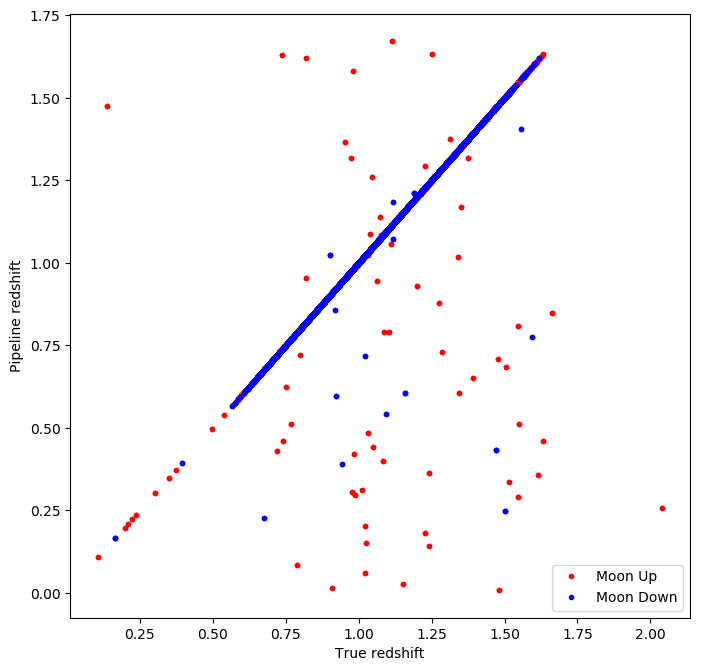

In [77]:
import matplotlib.pyplot as plt


# Observed redshift versus true redshift.
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)

p1  = axes.plot(truez_up[ok_up], z_up[ok_up], 'r.', label='Moon Up')
p2  = axes.plot(truez_dn[ok_dn], z_dn[ok_dn], 'b.', label='Moon Down')

foo = axes.set_xlabel('True redshift')
foo = axes.set_ylabel('Pipeline redshift')

foo = axes.legend(loc=4)

In [78]:
# Print the table columns and their types.
[(c.name, c.type) for c in ZCat.__table__.columns]

[('targetid', BigInteger()),
 ('chi2', Float()),
 ('coeff_0', Float()),
 ('coeff_1', Float()),
 ('coeff_2', Float()),
 ('coeff_3', Float()),
 ('coeff_4', Float()),
 ('coeff_5', Float()),
 ('coeff_6', Float()),
 ('coeff_7', Float()),
 ('coeff_8', Float()),
 ('coeff_9', Float()),
 ('z', Float()),
 ('zerr', Float()),
 ('zwarn', BigInteger()),
 ('npixels', BigInteger()),
 ('spectype', String()),
 ('subtype', String()),
 ('ncoeff', BigInteger()),
 ('deltachi2', Float()),
 ('brickname', String()),
 ('numexp', Integer()),
 ('numtile', Integer())]

In [79]:
type(tt[0][0])

desispec.database.redshift.Truth

In [80]:
dir(tt[0][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'bal_templateid',
 'd4000',
 'ewhbeta',
 'ewoii',
 'feh',
 'flux_g',
 'flux_r',
 'flux_w1',
 'flux_w2',
 'flux_w3',
 'flux_w4',
 'flux_z',
 'hbetaflux',
 'logg',
 'mabs_1450',
 'mag',
 'magfilter',
 'metadata',
 'mockid',
 'niihbeta',
 'oiidoublet',
 'oiiflux',
 'oiihbeta',
 'oiiihbeta',
 'seed',
 'siihbeta',
 'targetid',
 'teff',
 'templateid',
 'templatesubtype',
 'templatetype',
 'truespectype',
 'truez',
 'truez_norsd',
 'vdisp']

In [81]:
tt[0][0]

<Truth(targetid=288230398217945088)>

In [82]:
type(tt[0][1])

desispec.database.redshift.Target

In [83]:
dir(tt[0][1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'allmask_g',
 'allmask_r',
 'allmask_z',
 'bgs_target',
 'brick_objid',
 'brickid',
 'brickname',
 'dchisq_comp',
 'dchisq_dev',
 'dchisq_exp',
 'dchisq_psf',
 'dchisq_rex',
 'dec',
 'dec_ivar',
 'desi_target',
 'ebv',
 'fiberflux_g',
 'fiberflux_r',
 'fiberflux_z',
 'fibertotflux_g',
 'fibertotflux_r',
 'fibertotflux_z',
 'flux_g',
 'flux_ivar_g',
 'flux_ivar_r',
 'flux_ivar_w1',
 'flux_ivar_w2',
 'flux_ivar_w3',
 'flux_ivar_w4',
 'flux_ivar_z',
 'flux_r',
 'flux_w1',
 'flux_w2',
 'flux_

In [84]:
type(zz[0][0])

desispec.database.redshift.Truth

In [85]:
dir(zz[0][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'bal_templateid',
 'd4000',
 'ewhbeta',
 'ewoii',
 'feh',
 'flux_g',
 'flux_r',
 'flux_w1',
 'flux_w2',
 'flux_w3',
 'flux_w4',
 'flux_z',
 'hbetaflux',
 'logg',
 'mabs_1450',
 'mag',
 'magfilter',
 'metadata',
 'mockid',
 'niihbeta',
 'oiidoublet',
 'oiiflux',
 'oiihbeta',
 'oiiihbeta',
 'seed',
 'siihbeta',
 'targetid',
 'teff',
 'templateid',
 'templatesubtype',
 'templatetype',
 'truespectype',
 'truez',
 'truez_norsd',
 'vdisp']

In [86]:
type(zz[0][1])

desispec.database.redshift.ZCat

In [87]:
dir(zz[0][1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'brickname',
 'chi2',
 'coeff_0',
 'coeff_1',
 'coeff_2',
 'coeff_3',
 'coeff_4',
 'coeff_5',
 'coeff_6',
 'coeff_7',
 'coeff_8',
 'coeff_9',
 'deltachi2',
 'metadata',
 'ncoeff',
 'npixels',
 'numexp',
 'numtile',
 'spectype',
 'subtype',
 'targetid',
 'z',
 'zerr',
 'zwarn']

In [88]:
import numpy as np

np.unique(zz[0][1].zwarn, return_counts=True)

(array([0]), array([1]))

In [89]:
type(ff[0][0])

desispec.database.redshift.Truth

In [90]:
dir(ff[0][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'bal_templateid',
 'd4000',
 'ewhbeta',
 'ewoii',
 'feh',
 'flux_g',
 'flux_r',
 'flux_w1',
 'flux_w2',
 'flux_w3',
 'flux_w4',
 'flux_z',
 'hbetaflux',
 'logg',
 'mabs_1450',
 'mag',
 'magfilter',
 'metadata',
 'mockid',
 'niihbeta',
 'oiidoublet',
 'oiiflux',
 'oiihbeta',
 'oiiihbeta',
 'seed',
 'siihbeta',
 'targetid',
 'teff',
 'templateid',
 'templatesubtype',
 'templatetype',
 'truespectype',
 'truez',
 'truez_norsd',
 'vdisp']

In [91]:
type(ff[0][1])

desispec.database.redshift.FiberAssign

In [92]:
dir(ff[0][1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'device_loc',
 'fa_target',
 'fa_type',
 'fiber',
 'fiberassign_x',
 'fiberassign_y',
 'fiberstatus',
 'lambda_ref',
 'location',
 'metadata',
 'numobs_more',
 'numtarget',
 'objtype',
 'obsconditions',
 'petal_loc',
 'pmdec',
 'pmdec_ivar',
 'pmra',
 'pmra_ivar',
 'priority',
 'ref_epoch',
 'subpriority',
 'target_dec',
 'target_ra',
 'targetid',
 'tileid']

# QA

## Initialize QA output directory

In [93]:
import desispec

# New dir to define and make
qaprod_dir = desispec.io.qaprod_root()
os.makedirs(qaprod_dir, exist_ok=True)
qaprod_dir

'/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA'

In [94]:
#- Helper function for timing QA commands
def time_command(cmd, logfile):
    t0 = time.time()
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    if err != 0:
        print('FAILED: {}'.format(cmd))

    dt = time.time() - t0
    if dt < 60:
        print('"{}" took {:.1f} seconds'.format(cmd, time.time()-t0))
    else:
        print('"{}" took {:.1f} minutes'.format(cmd, dt/60))
    return err

### QA with the Truth

The following QA uses the input truth table.  

In [95]:
qat_logname = os.path.join(qaprod_dir, 'qa_truth.log')
print('logging truth-based QA to {}'.format(qat_logname))

logging truth-based QA to /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA/qa_truth.log


In [96]:
import time, glob, subprocess

qa0_time = time.time()

with open(qat_logname, 'w') as logfile:
    if len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10:
        print("S/N figures already exist")
        
    else:
        # S/N (~7min)
        cmd = "desi_qa_s2n --qaprod_dir={:s}".format(qaprod_dir)
        time_command(cmd, logfile)
    
    # zfind (~2min)
    if (len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6) and os.path.exists(qaprod_dir+'/QA_dzsumm.png'):
        print("zfind figures already exist")

    else:
        cmd = "desi_qa_zfind --yaml_file={:s}/dzsumm_stats.yaml --qaprod_dir={:s}".format(qaprod_dir, qaprod_dir) 
        time_command(cmd, logfile)
    
# Time me
print("Done with QA with truth at {}".format(time.asctime()))

qa_truth_time = time.time() - qa0_time

print("That took {:.1f} minutes".format(qa_truth_time/60))

Fri Dec 27 11:09:17 2019 RUNNING desi_qa_s2n --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA
"desi_qa_s2n --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA" took 5.5 minutes
Fri Dec 27 11:14:46 2019 RUNNING desi_qa_zfind --yaml_file=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA/dzsumm_stats.yaml --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA
"desi_qa_zfind --yaml_file=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA/dzsumm_stats.yaml --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA" took 40.5 seconds
Done with QA with truth at Fri Dec 27 11:15:27 2019
That took 6.2 minutes


### Check

In [97]:
assert len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10
assert len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6
assert os.path.exists(qaprod_dir+'/QA_dzsumm.png')

### Show

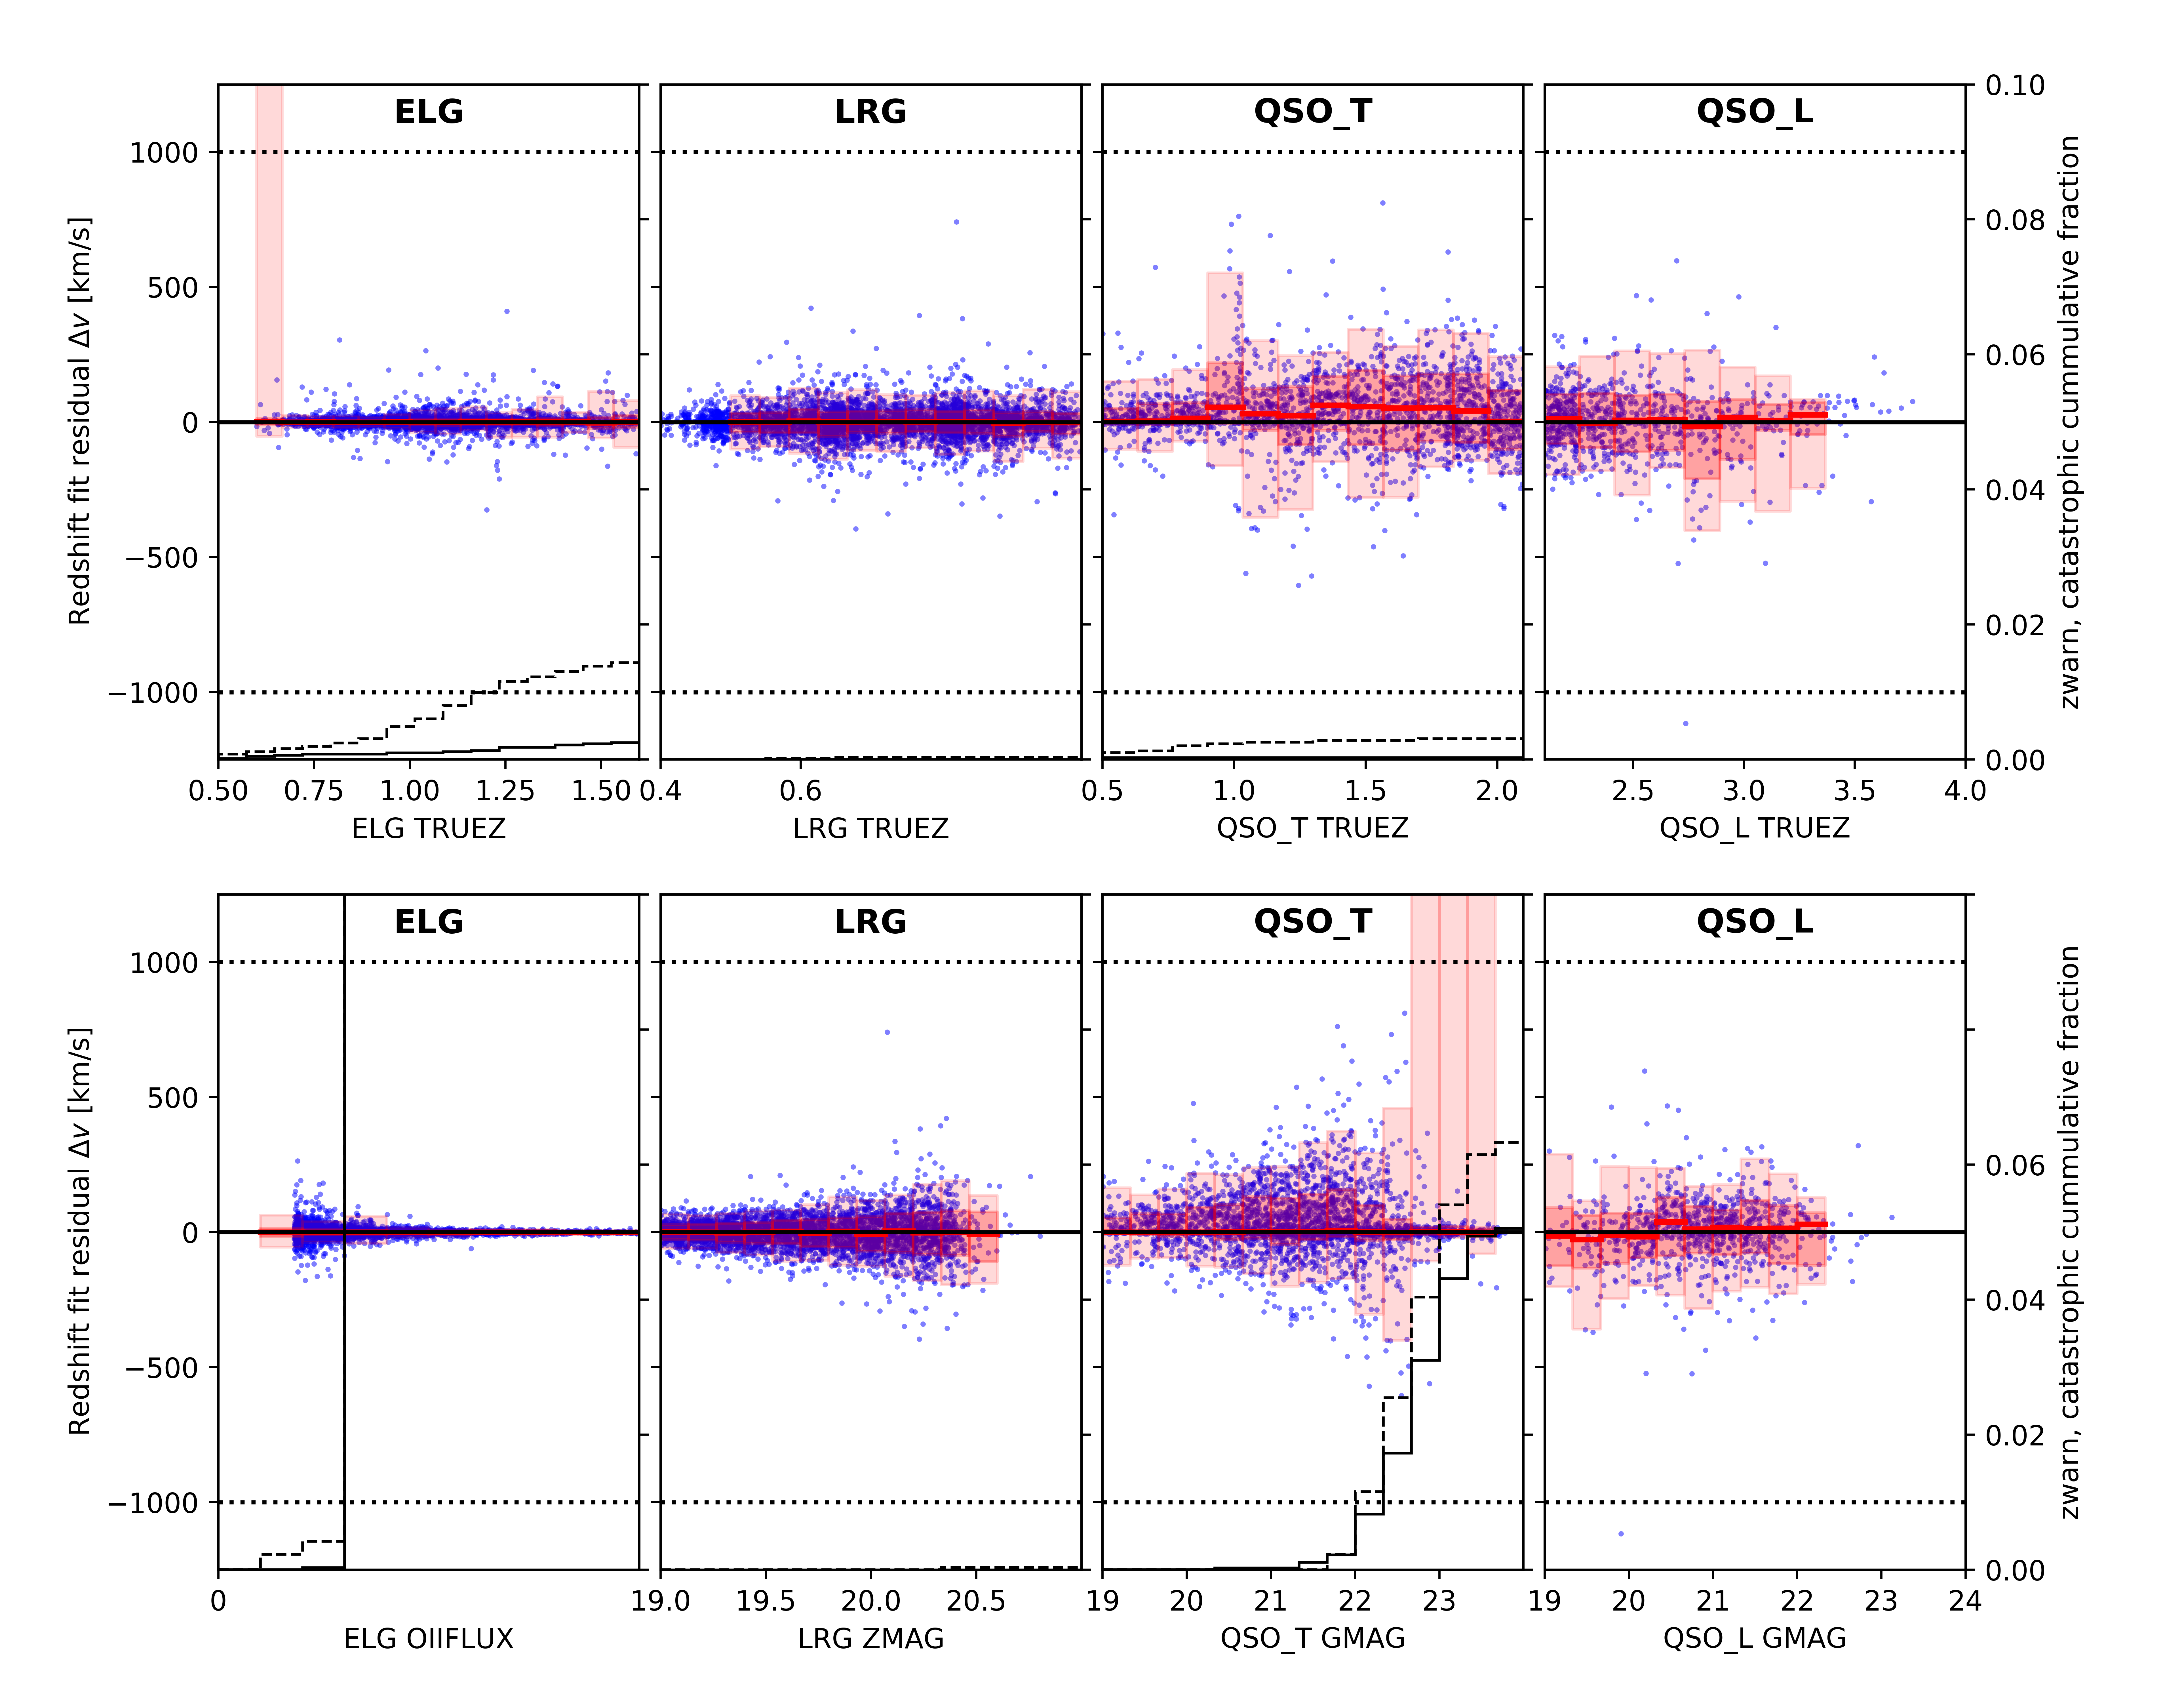

In [98]:
from IPython.display import Image, display
Image(filename=qaprod_dir+'/QA_dzsumm.png') 

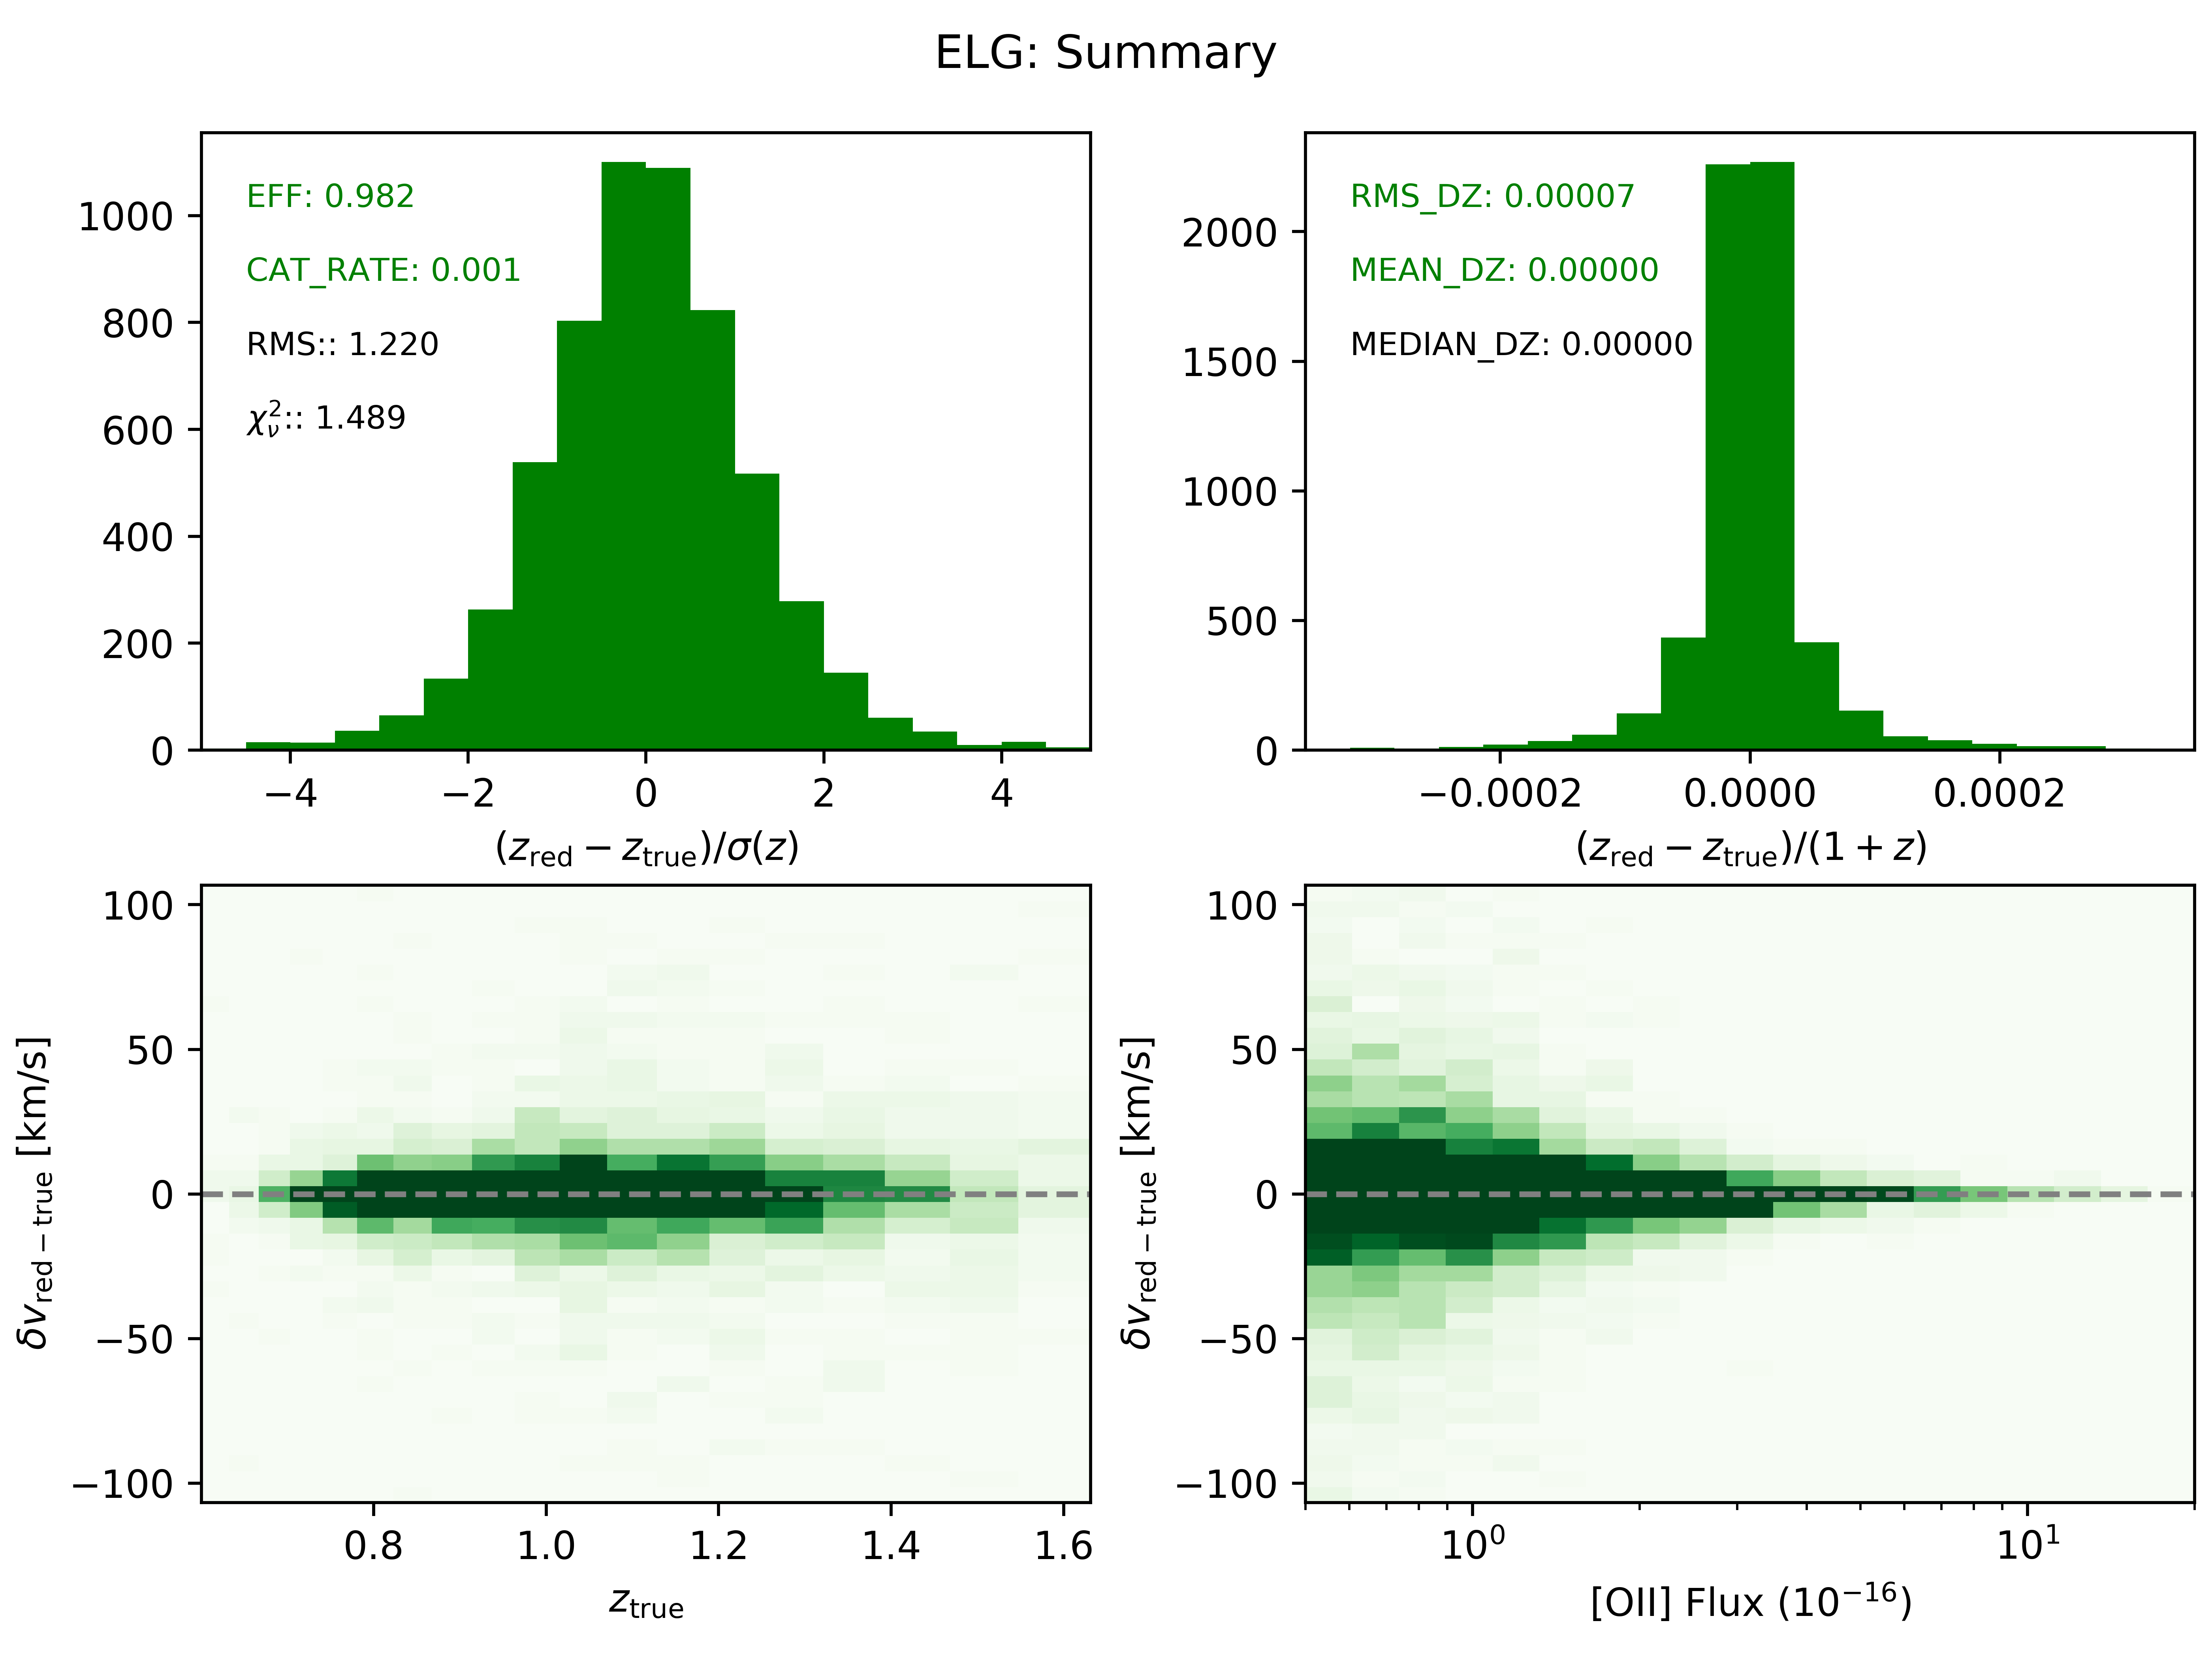

In [99]:
Image(filename=qaprod_dir+'/QA_zfind_ELG.png', width=500)

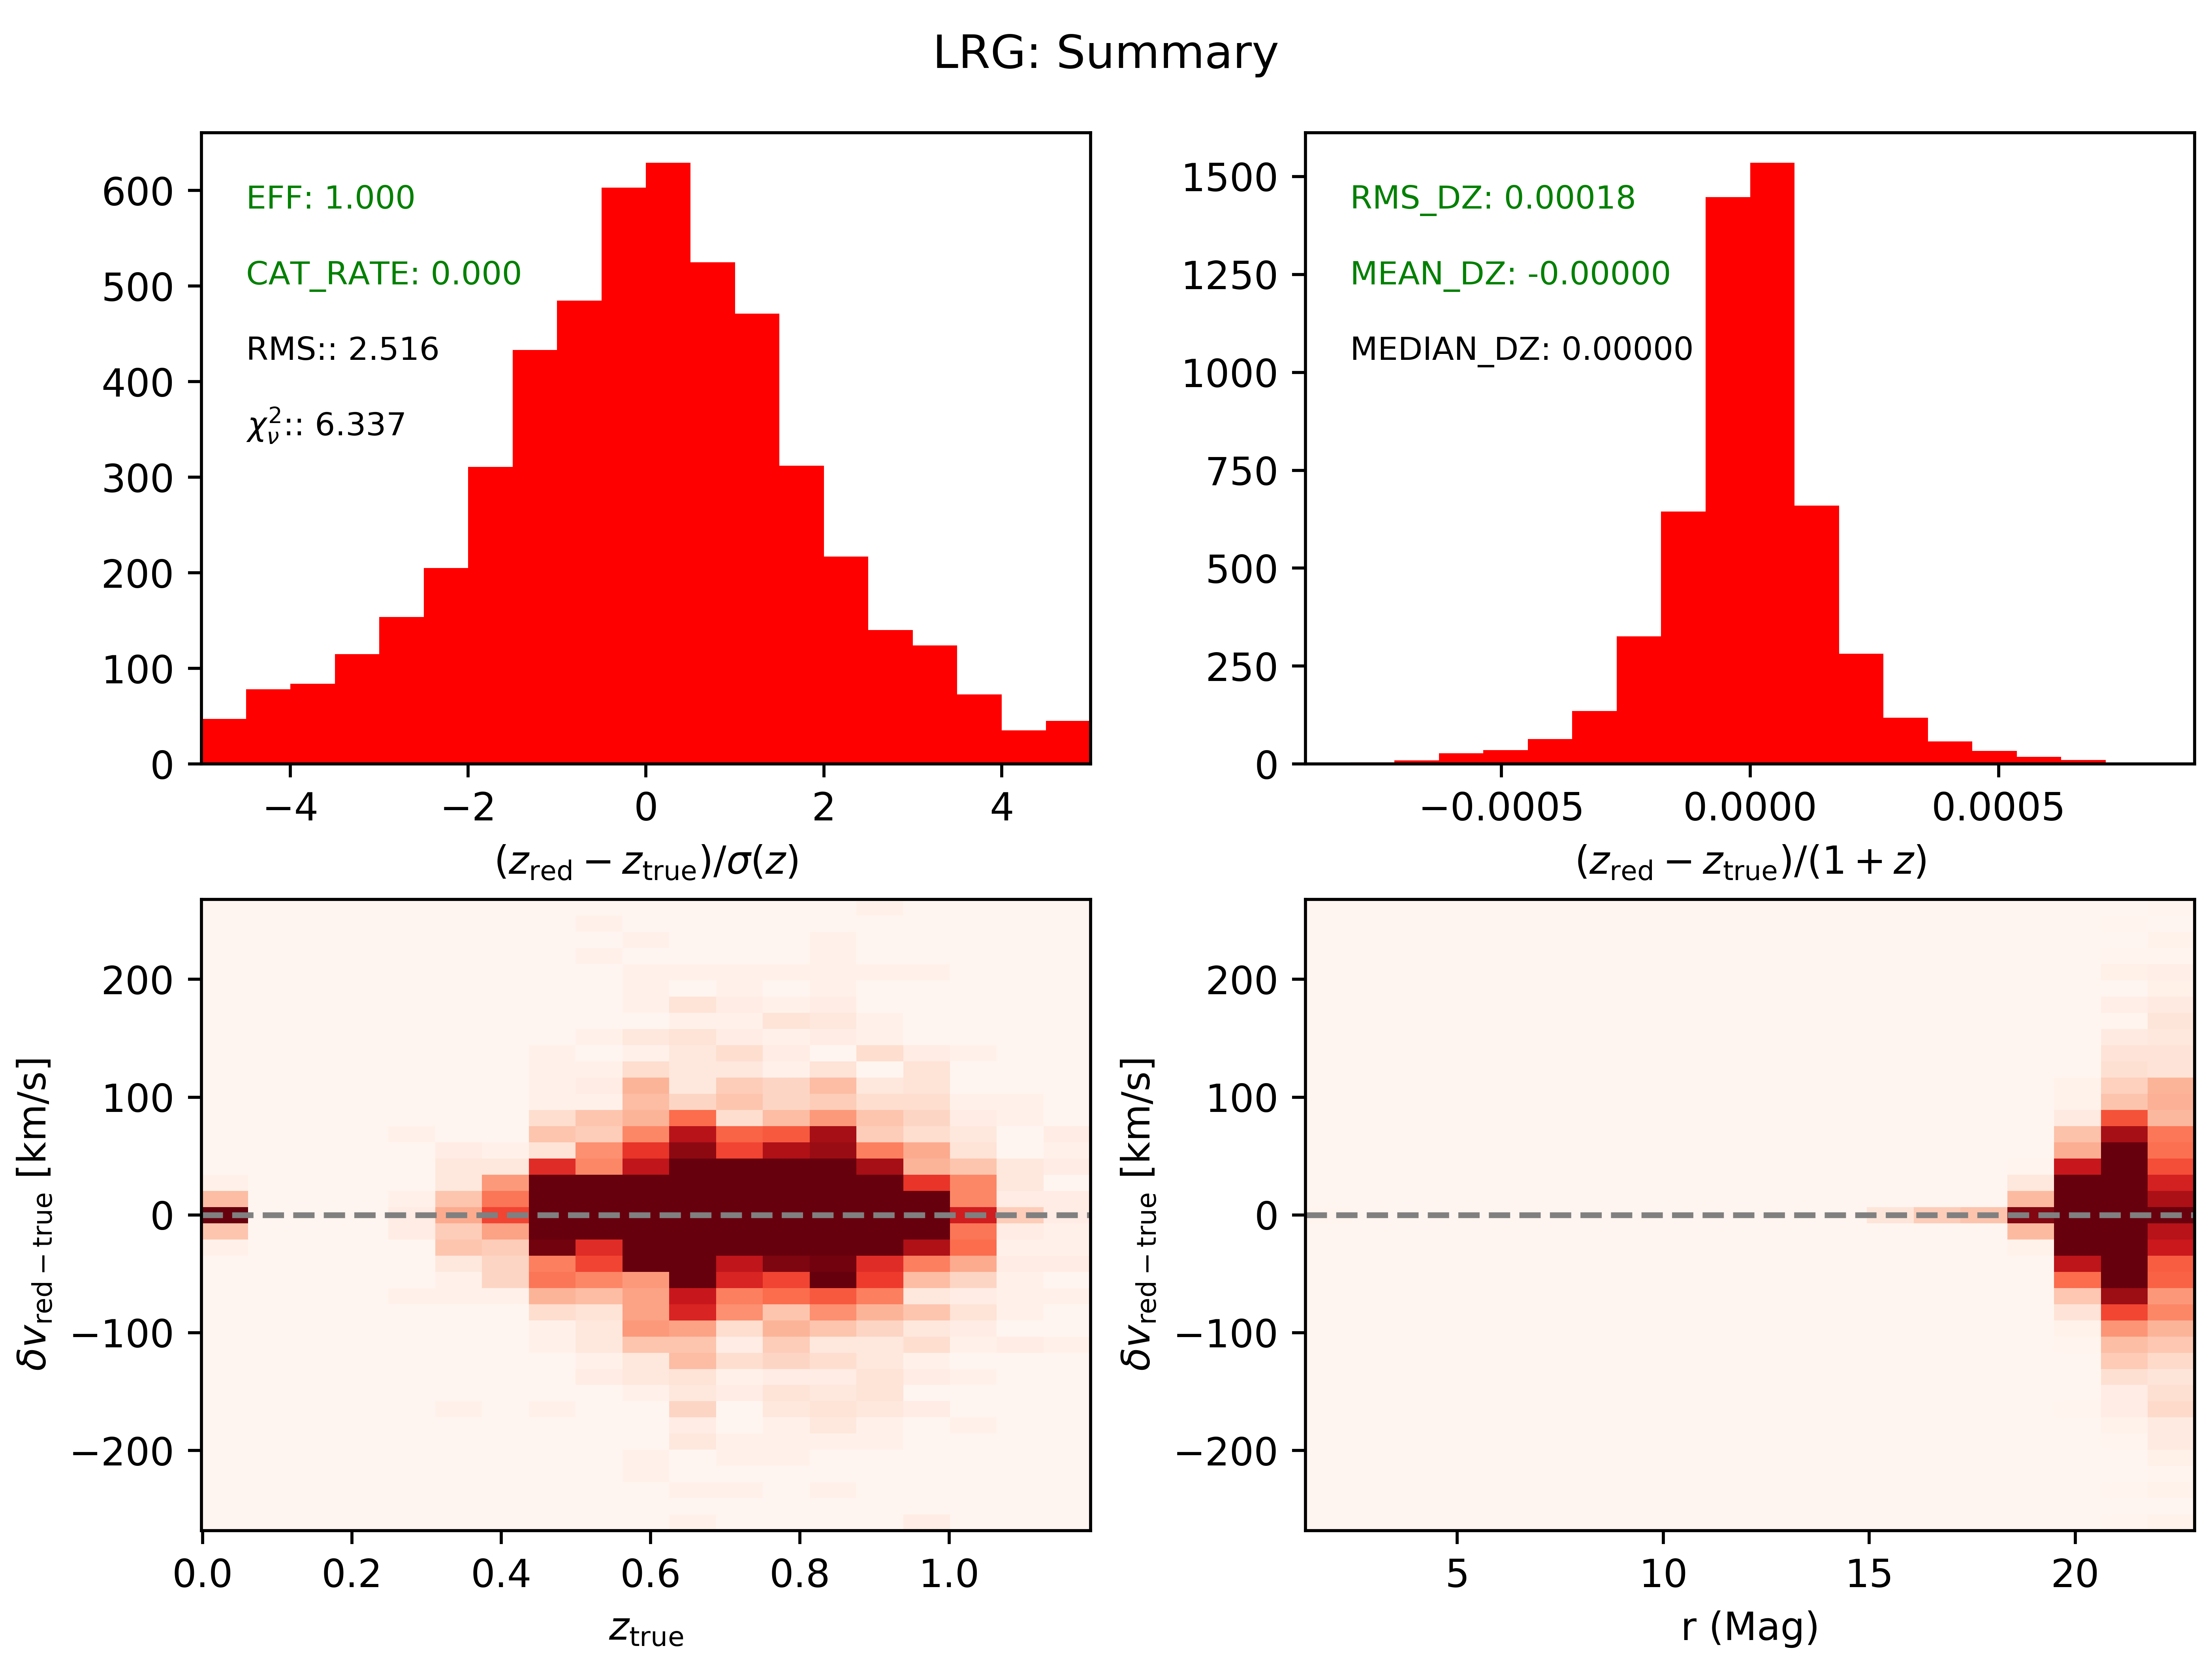

In [100]:
Image(filename=qaprod_dir+'/QA_zfind_LRG.png', width=500)

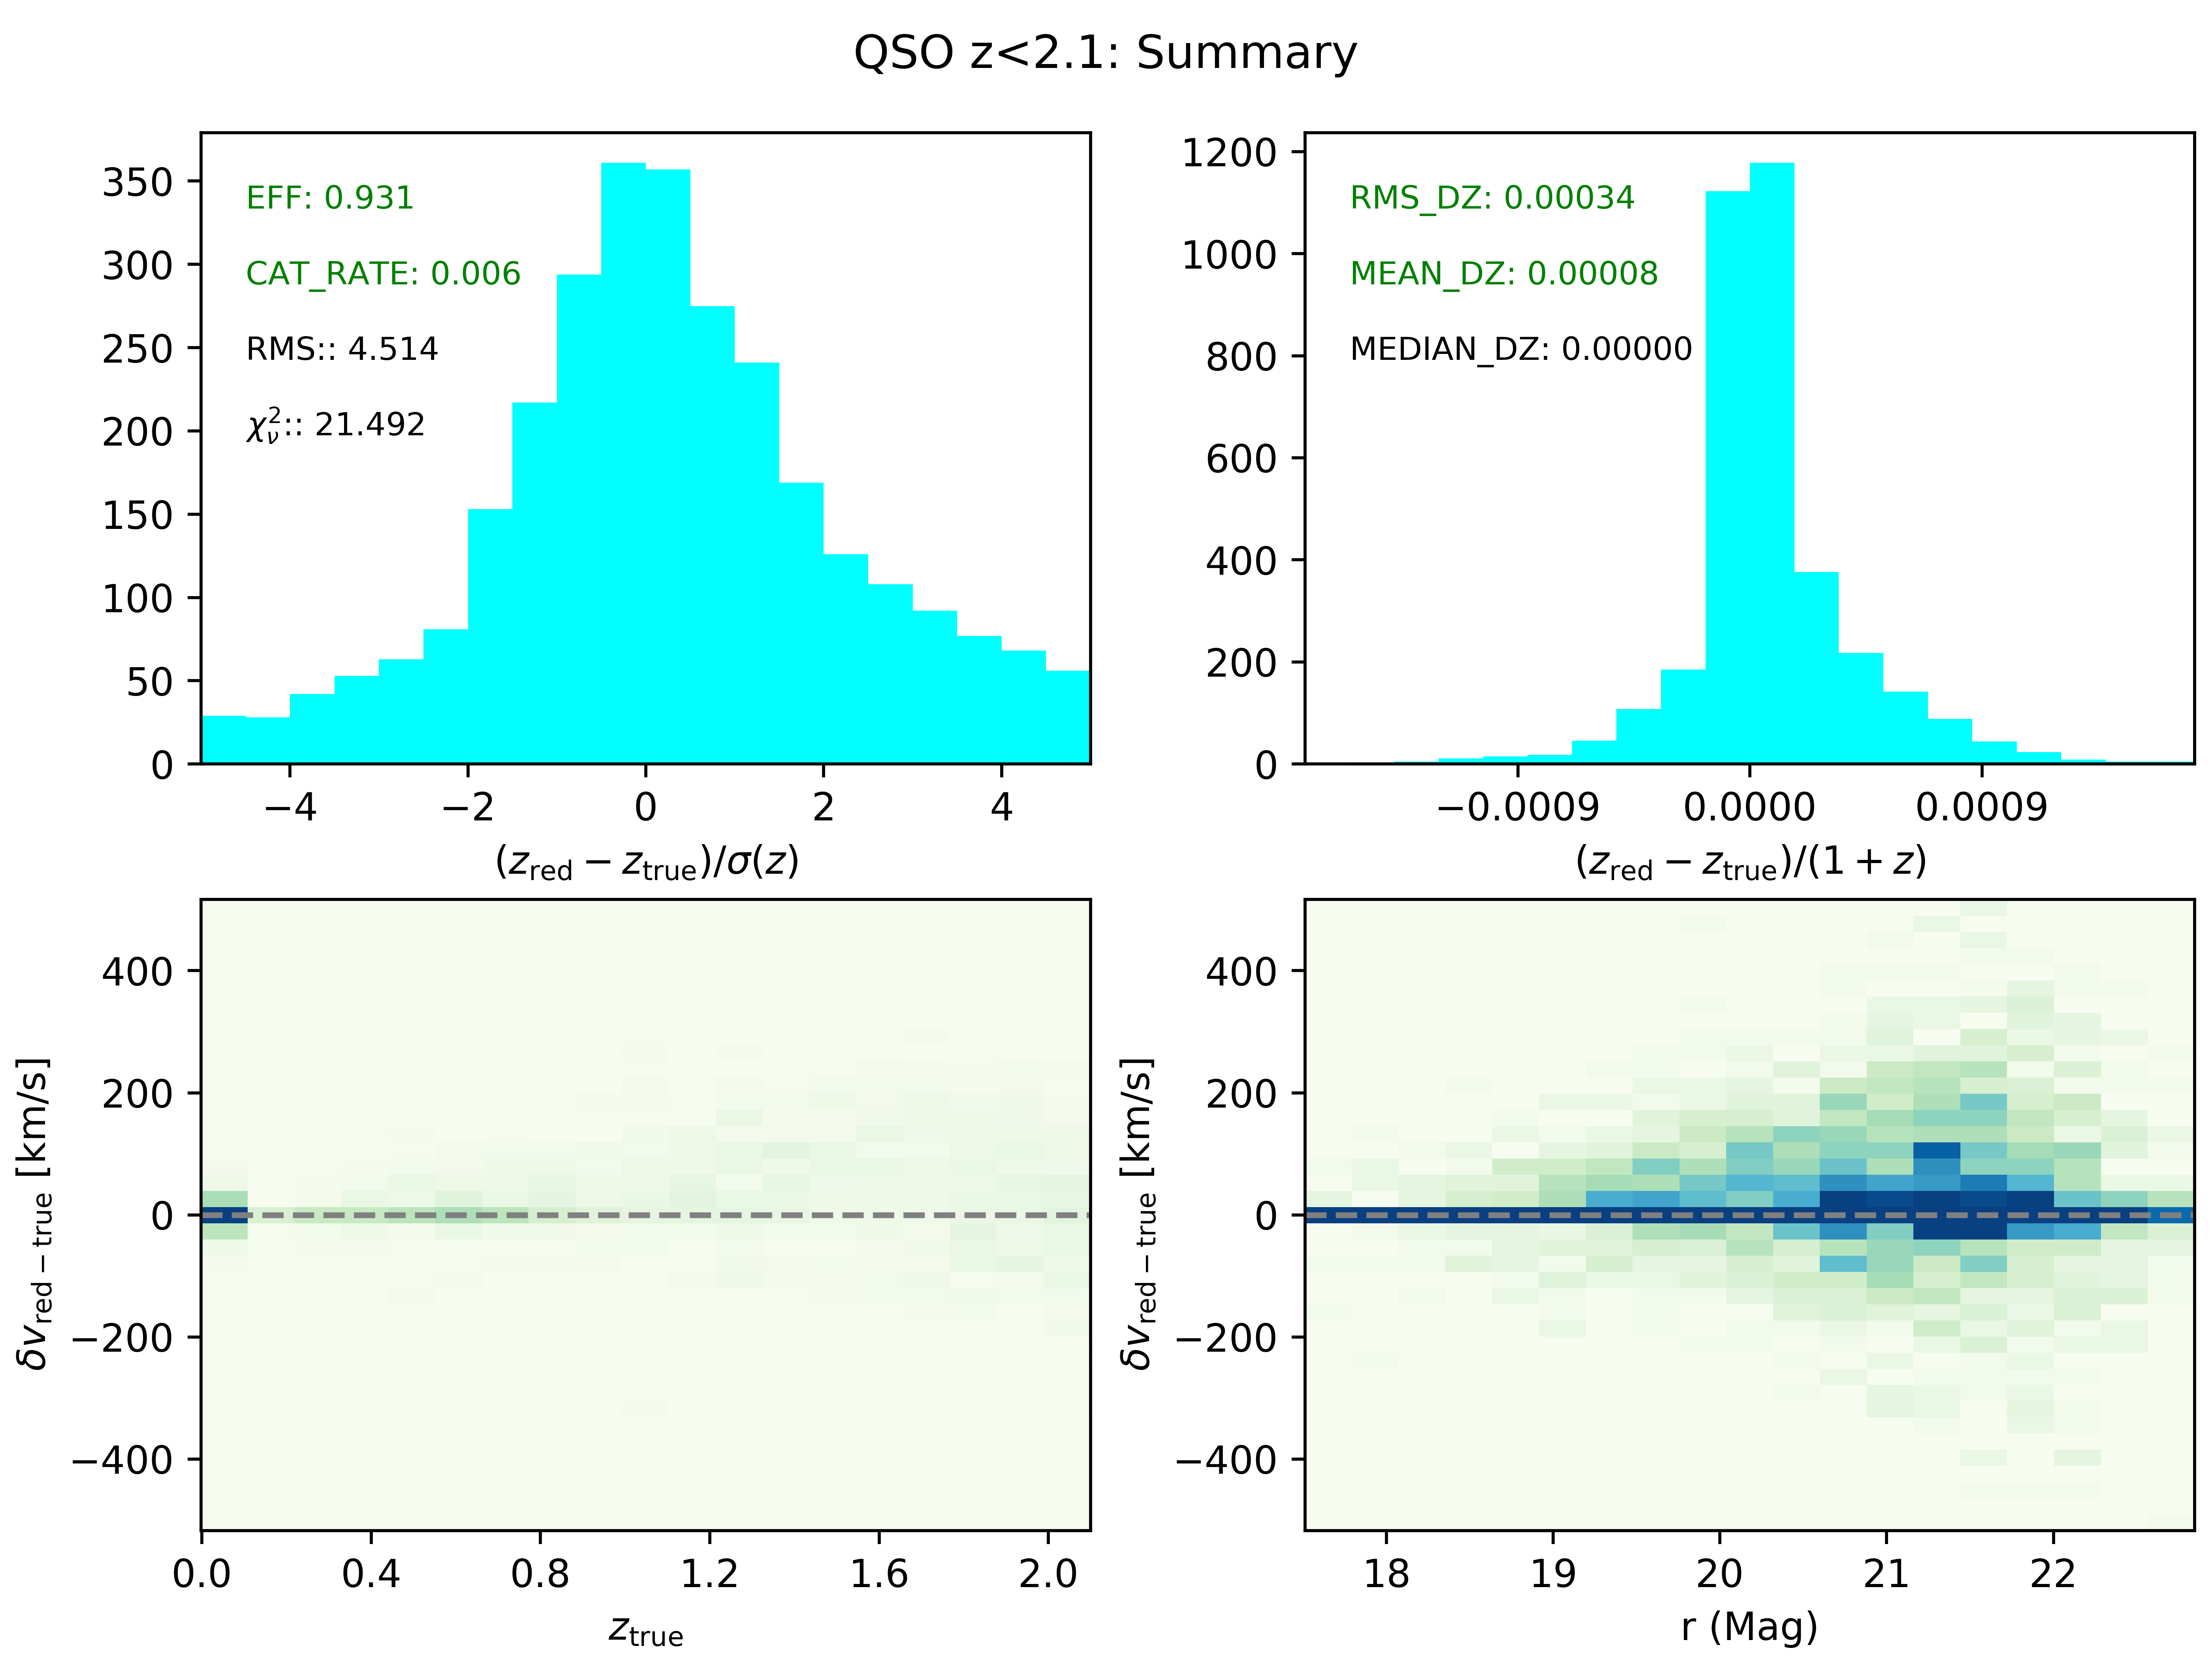

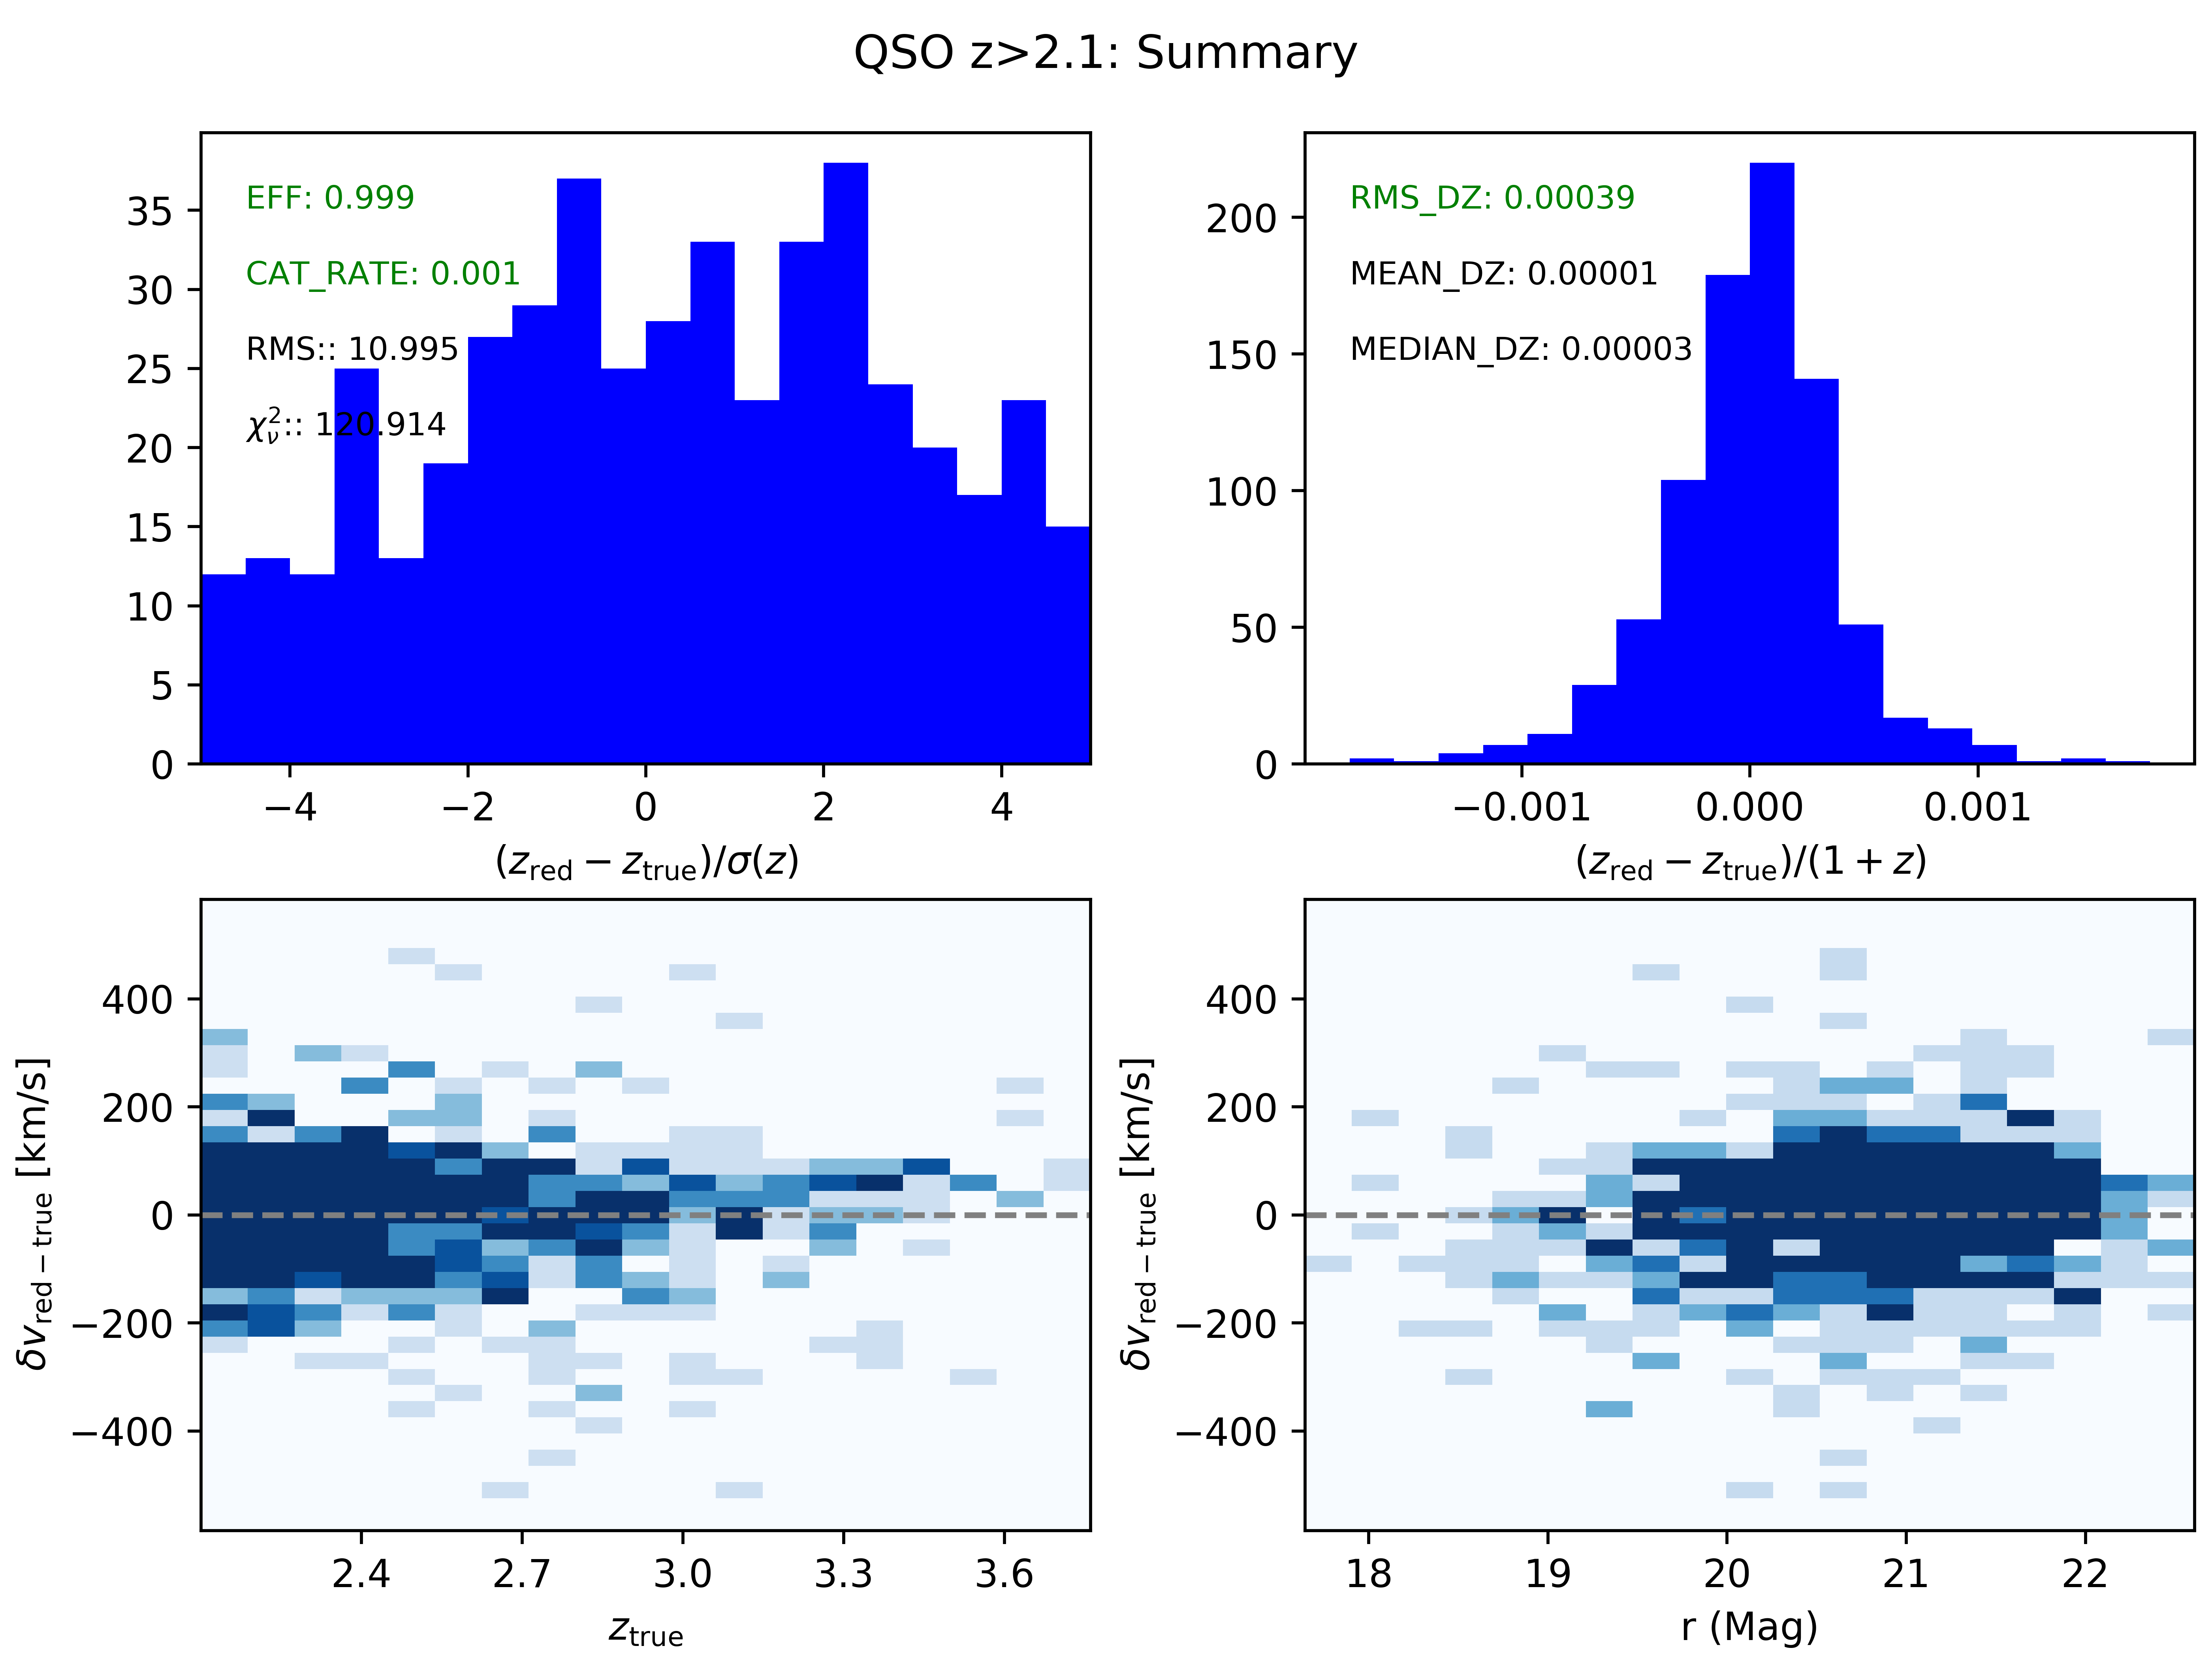

In [101]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_QSO_T.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_QSO_L.png', width=500),
)

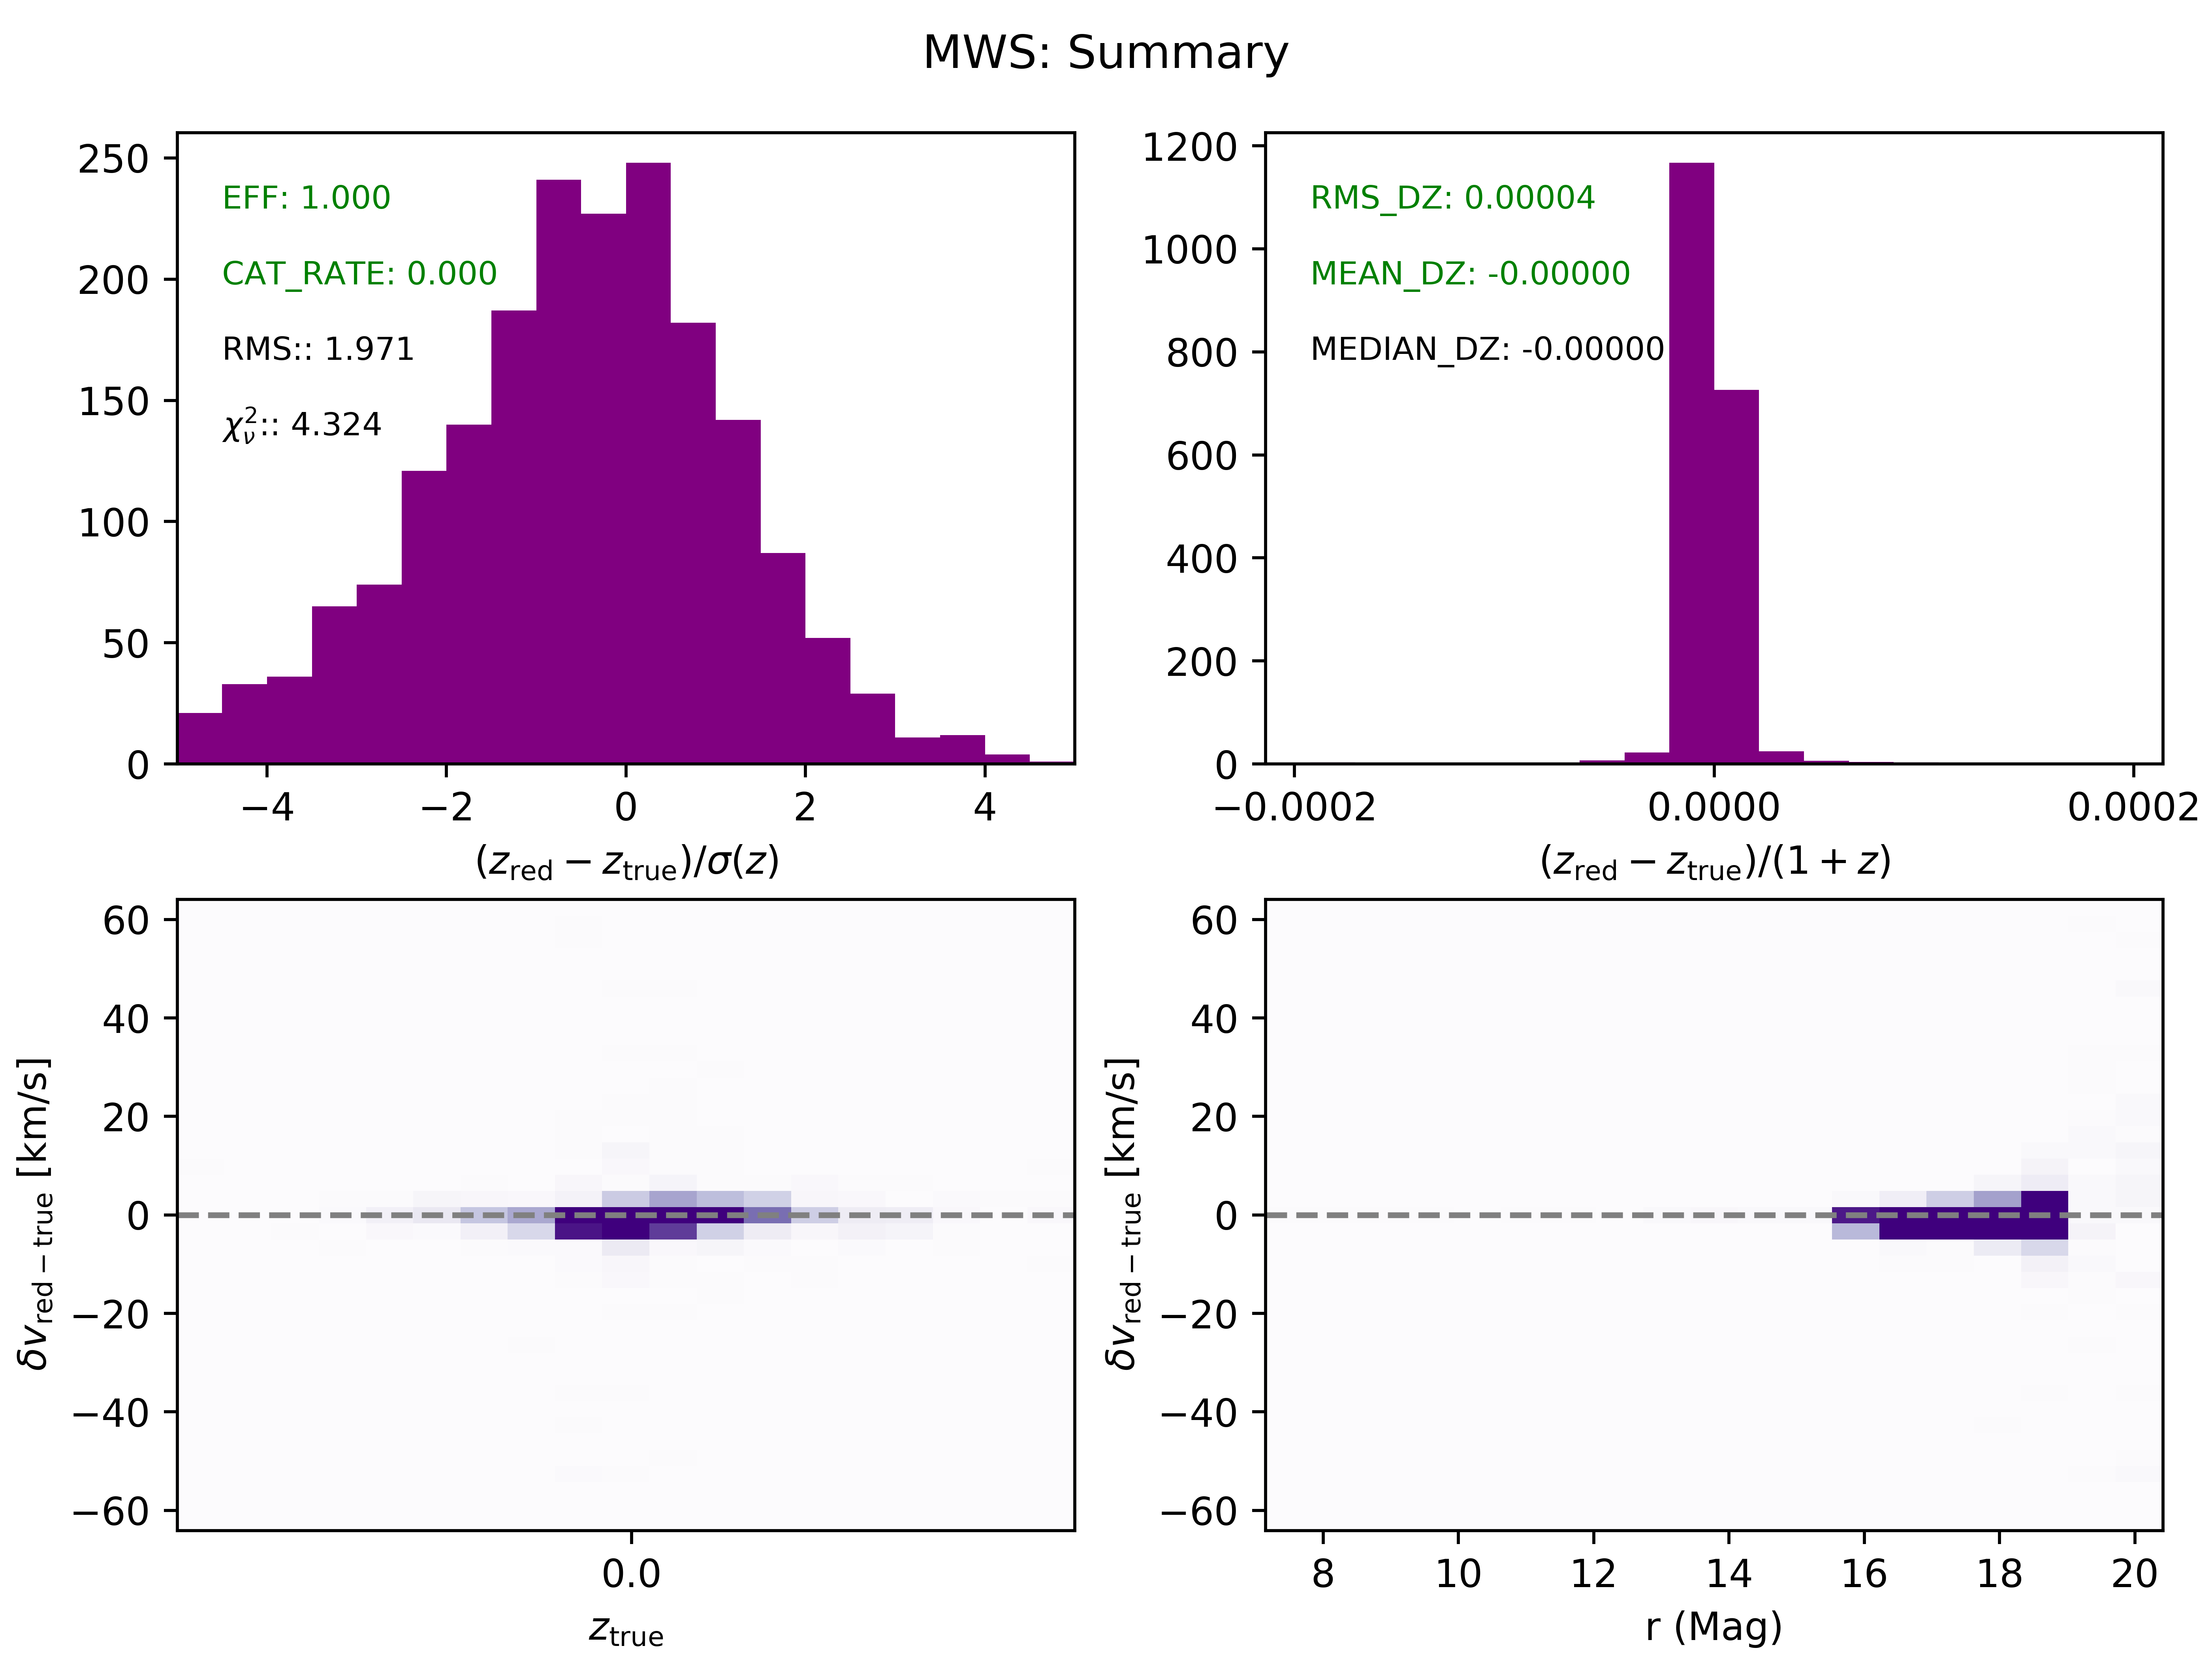

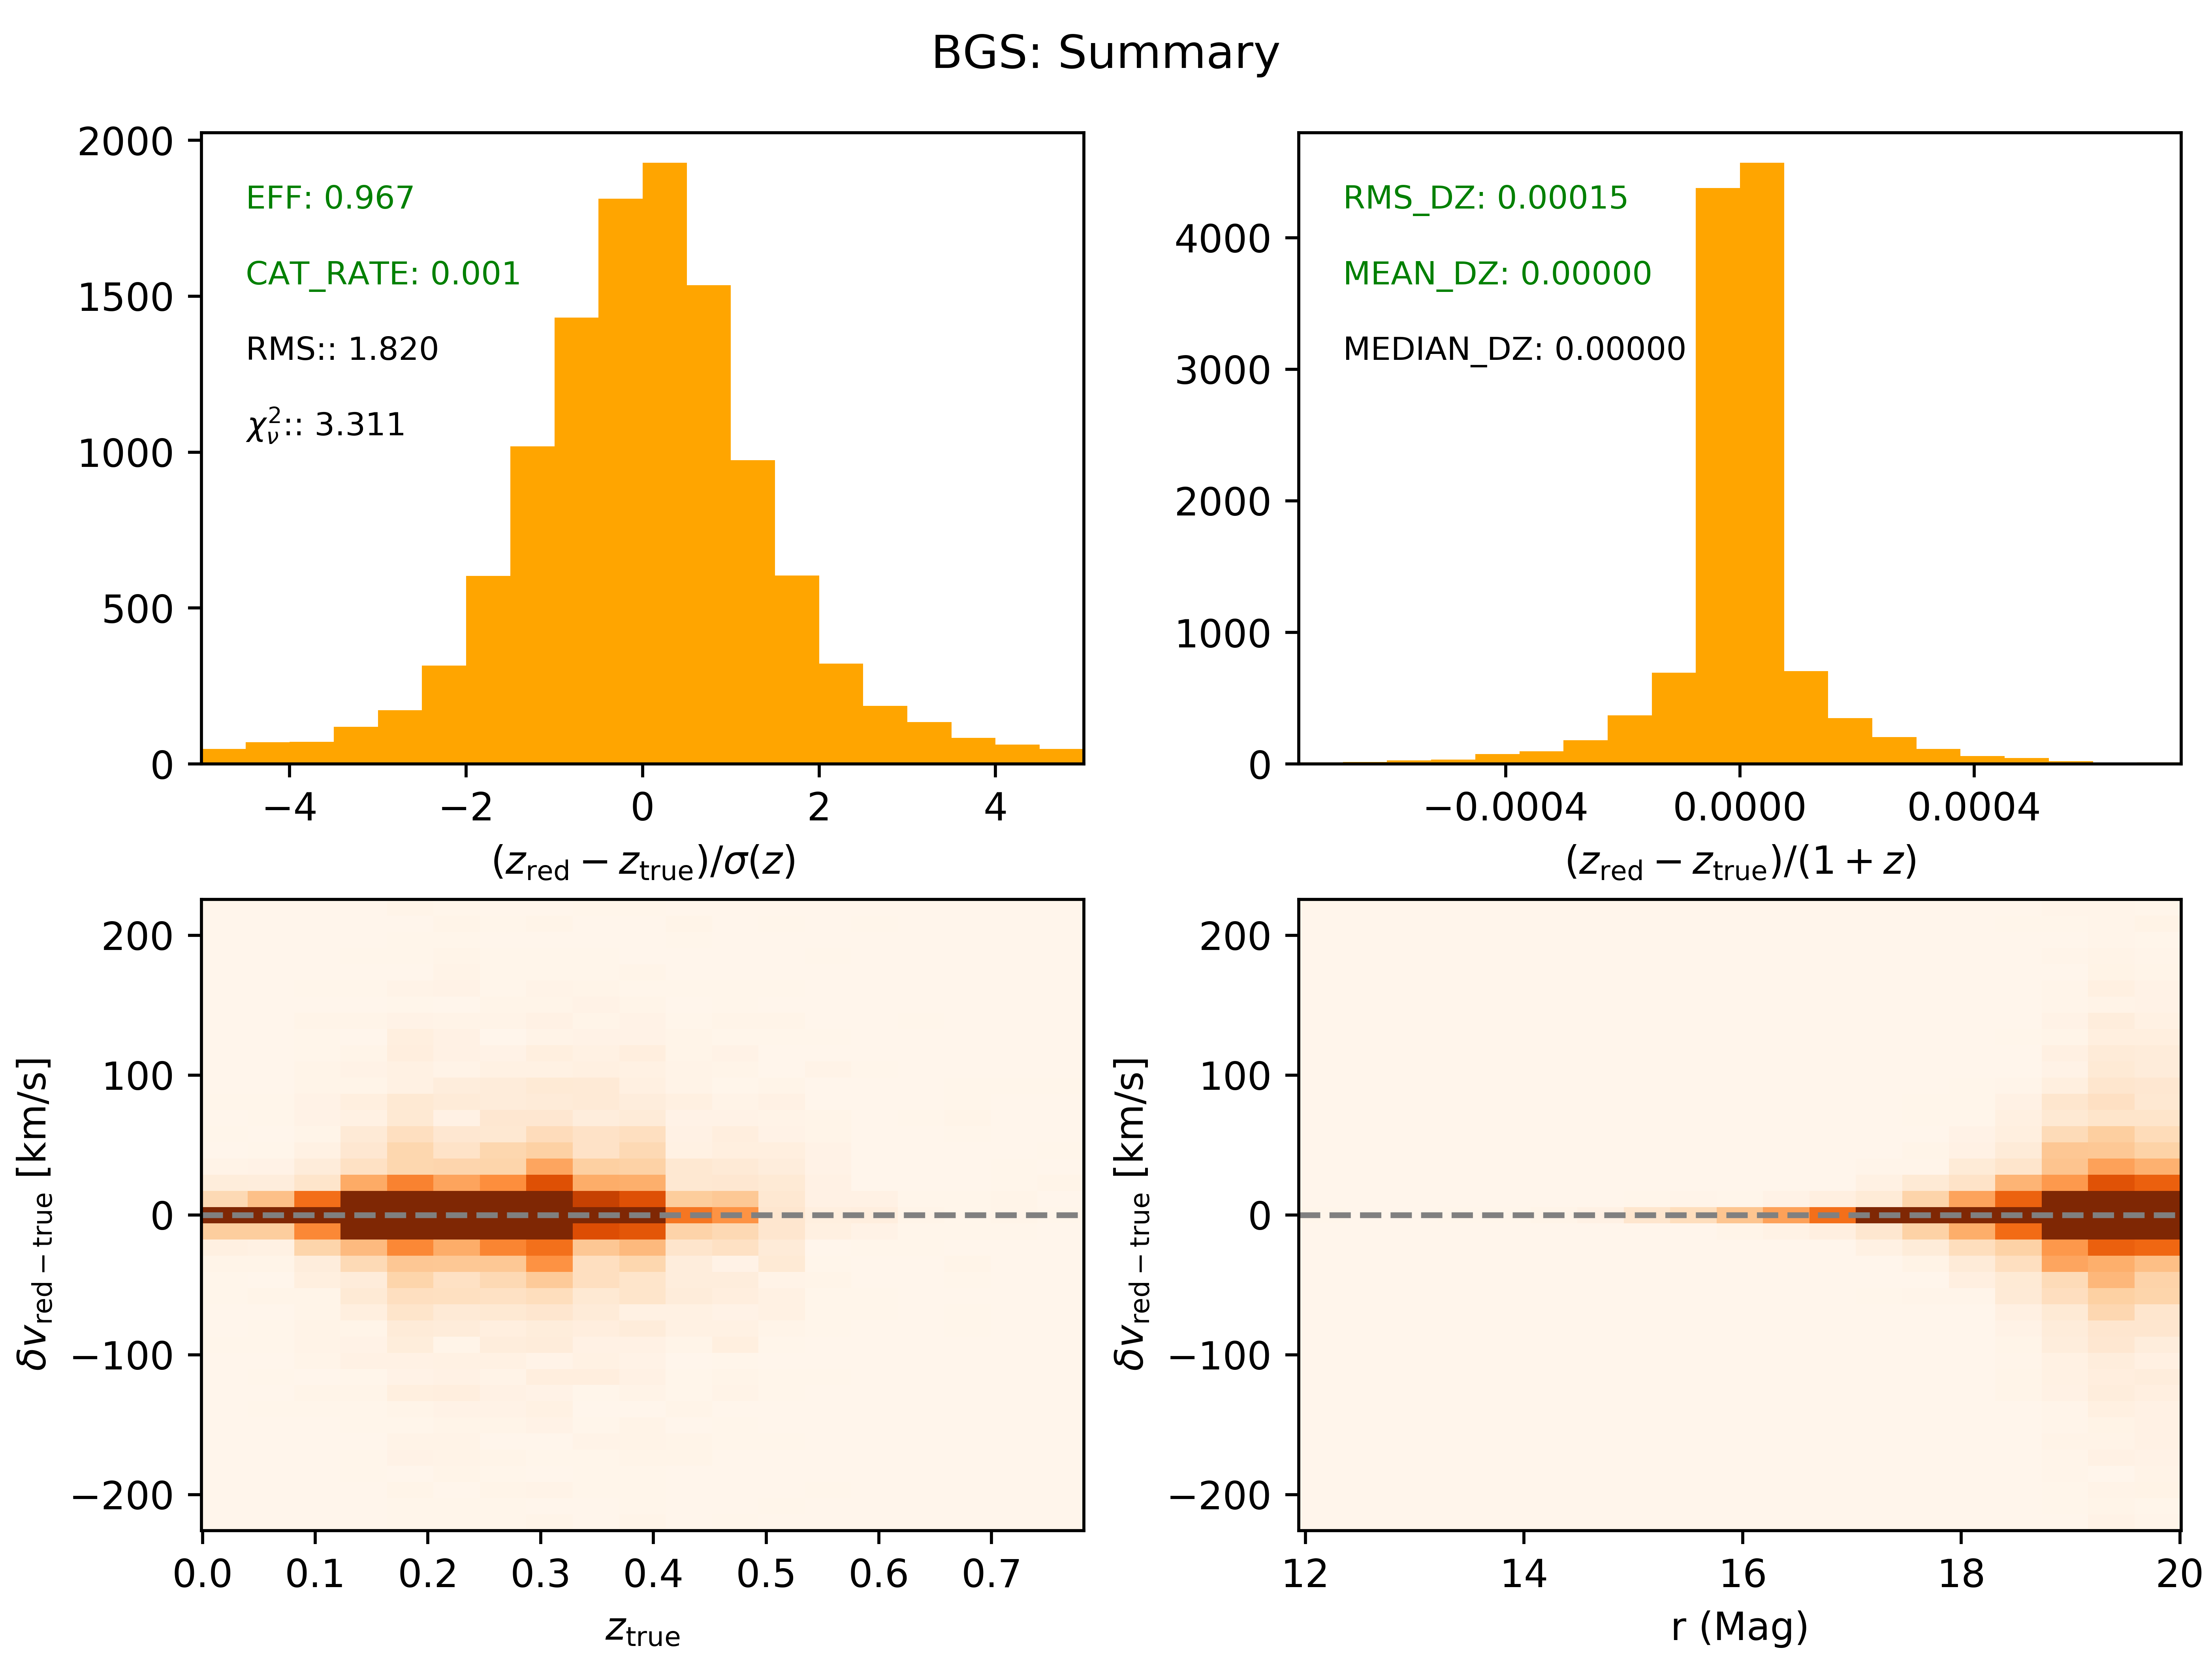

In [102]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_MWS.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_BGS.png', width=500),
)

In [103]:
print("Timing checkpoint at {}".format(time.asctime()))
tmp_time = time.time() - notebook_start_time
print("{:.1f} minutes so far".format(tmp_time/60))

Timing checkpoint at Fri Dec 27 11:15:27 2019
132.0 minutes so far


## Offline QA

This can take several hours (!) depending upon $SCRATCH latency

In [104]:
qant_logname = os.path.join(qaprod_dir, 'qa_notruth.log')
print('Logging specto QA to {}'.format(qant_logname))

Logging specto QA to /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA/qa_notruth.log


In [105]:
# Generate the QA (if it doesn't exist already)
qa_start_time = time.time()
with open(qant_logname, 'w') as logfile:
    
    if os.path.exists(qaprod_dir+'/'+os.environ['SPECPROD']+'_qa.json'):
        print("Skipping generating full prod QA file")
    else:
        # Generate yaml files and figures (30min to >1hour depending upon $SCRATCH latency)
        cmd = "desi_qa_prod --make_frameqa=3 --clobber --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))

        # Slurp (fast)
        cmd = "desi_qa_prod --slurp --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))
    
    # Skyresid (~8min for the two)
    if len(glob.glob(qaprod_dir+'/skyresid_prod_dual*')) == 3:
        print("Skipping generating SkyResid figures")
    else:
        cmd = "desi_qa_skyresid --prod --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))

    if len(glob.glob(qaprod_dir+'/skyresid_prod_gauss*')) == 3:
        print("Skipping generating SkyResid Gaussianity figures")
    else:    
        cmd = "desi_qa_skyresid --gauss --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))
    
    # HTML
    cmd = "desi_qa_prod --html --qaprod_dir={:s}".format(qaprod_dir)
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    if err:
        raise RuntimeError('see {}'.format(qant_logname))

    
# Time me
print("Done with QA without truth at {}".format(time.asctime()))
qa1_time = time.time() - qa_start_time
print("That took {:.1f} minutes".format(qa1_time/60))

Fri Dec 27 11:15:27 2019 RUNNING desi_qa_prod --make_frameqa=3 --clobber --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA
Fri Dec 27 11:15:29 2019 RUNNING desi_qa_prod --slurp --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA
Fri Dec 27 11:15:32 2019 RUNNING desi_qa_skyresid --prod --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA
Fri Dec 27 11:19:31 2019 RUNNING desi_qa_skyresid --gauss --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA
Fri Dec 27 11:24:22 2019 RUNNING desi_qa_prod --html --qaprod_dir=/global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA


RuntimeError: see /global/cscratch1/sd/sjbailey/minitest-19.12/spectro/redux/mini/QA/qa_notruth.log

### Check

In [ ]:
# JSON file
prod_qa = desispec.io.qa.load_qa_multiexp(qaprod_dir+'/'+os.environ['SPECPROD']+'_qa')
assert isinstance(prod_qa, dict)
assert len(prod_qa.keys()) == 4
# PNGs
assert len(glob.glob(qaprod_dir+'/skyresid_prod_dual*')) == 3
assert len(glob.glob(qaprod_dir+'/skyresid_prod_gauss*')) == 3
# HTML
assert os.path.exists(qaprod_dir+'/qa-toplevel.html')

### Show

In [ ]:
from IPython.display import Image
Image(filename=qaprod_dir+'/skyresid_prod_dual_r.png')

## Finish Up

In [ ]:
print("Done at {}".format(time.asctime()))
run_time = time.time() - notebook_start_time
print("That took {:.1f} minutes".format(run_time/60))

In [ ]:
# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<BR/>
pre-testing for 19.12 release, December 2019.